# Import libraries

In [290]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display


## Import Functions

### dslabs_functions

In [180]:
%run "scripts/dslabs_functions.py"

dslabs_functions lodaded


### data functions

In [181]:
%run "scripts/data_functions.py"


data_functions lodaded


# Load

In [291]:
#get file from data pre processing notebook. This file has all the column we need to start the data profiling phase
filepath = r'data/citi_bike_pre_proc.csv'

excel_mapping_filepath=r'data/citi_bike_values_encoded.xlsx'

file_tag = 'Citi Bike'

#get file from data pre processing notebook. This file has all the column we need to start the data profiling phase

In [314]:
test_data = True
# test_data = False

# Load the data
if test_data:
    df = pd.read_csv(filepath, na_values="")

    df: DataFrame = df.sample(frac=0.004, replace = False)

else:
    # If not test_data, load the entire dataset
    df = pd.read_csv(filepath)

id_cols=['ride_id',
         'start_time', 
         'end_time',
         'start_station',
         'end_station',
         'start_station_id',
         'end_station_id',
         'start_lat',
         'start_lng', 
         #'hour',
         'end_lat', 
         'end_lng',
         'wmo_weather_code',
         'snowfall_cm',
         'ride_duration_sec']
#remove also col = 'snowfall_cm' because it has only 0 values in our dataset
#remove also start_station and end_Station = they have too many unique values(around 2k) which will make the encoding process very slow

# Remove unnecessary columns
df = df.drop(columns=id_cols, axis=1)

df_enc = df.copy()  # DataFrame com as variáveis codificadas

display(df_enc.info())
display(df_enc.shape)


#alterar consoante a necessidade:
#- se quiser considerar a remoçao de outliers, alterar para "df_prep_outl"
#- se nao quiser considerar a remoçao de outliers, alterar para "df_enc"
use_df_in_scaling = "df_prep_outl"  # Pode ser "df_enc" ou "df_prep_outl"
use_df_in_feat_eng = "df_prep_scal"  # Pode ser "df_enc", "df_prep_outl", "df_prep_scal"
use_df_in_clust = "df_prep_feat"  # Pode ser "df_enc", "df_prep_outl", "df_prep_scal", "df_prep_feat_eng"


<class 'pandas.core.frame.DataFrame'>
Index: 12774 entries, 2312025 to 89488
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bike_type            12774 non-null  object 
 1   user_type            12774 non-null  object 
 2   start_borough        12774 non-null  object 
 3   end_borough          12774 non-null  object 
 4   day_of_month         12774 non-null  int64  
 5   hour                 12774 non-null  int64  
 6   day_of_week          12774 non-null  object 
 7   is_weekend           12774 non-null  int64  
 8   time_of_day          12774 non-null  object 
 9   ride_duration_min    12774 non-null  float64
 10  temperature_2m       12774 non-null  float64
 11  rain_mm              12774 non-null  float64
 12  cloud_cover_low_pct  12774 non-null  int64  
 13  wind_speed_10m       12774 non-null  float64
 14  wmo_weather_desc     12774 non-null  object 
 15  ride_distance_km     12774 non-null

None

(12774, 17)

In [293]:
# Verificar se 'event_time' está presente e é do tipo datetime
if 'event_time' in df.columns and pd.api.types.is_datetime64_any_dtype(df['event_time']):
    # Conta o número de dias únicos
    num_unique_days = df['event_time'].nunique()
    print(f"Número de dias únicos: {num_unique_days}")
else:
    print("A coluna 'event_time' não existe ou não é do tipo datetime.")

# Contar valores distintos em todas as colunas
distinct_values = df.nunique()
print("Número de valores distintos por coluna:")
print(distinct_values)

A coluna 'event_time' não existe ou não é do tipo datetime.
Número de valores distintos por coluna:
bike_type                  2
user_type                  2
start_borough              5
end_borough                6
day_of_month              31
hour                      24
day_of_week                7
is_weekend                 2
time_of_day                6
ride_duration_min      12710
temperature_2m           211
rain_mm                   30
cloud_cover_low_pct       71
wind_speed_10m           256
wmo_weather_desc           9
ride_distance_km       12318
ride_avg_speed         12621
dtype: int64


# Cluster Data Enconding


### Change col time_of_day and day_of_week

In [315]:
#change time_of_day

def time_of_day(hour):
    if 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 22:
        return 'evening'
    else:
        return 'night'

df['time_of_day'] = df['hour'].apply(time_of_day)
df_enc['time_of_day'] = df_enc['hour'].apply(time_of_day)

#change day_of_week

#def weekday_group(day_of_week):
#    if day_of_week in ['Monday', 'Tuesday']:
#        return 'early_week'
#    elif day_of_week in ['Wednesday', 'Thursday']:
#        return 'mid_week'
#    else:  # Friday, Saturday, Sunday
#        return 'weekend'
#
#df_enc['weekday_group'] = df_enc['day_of_week'].apply(weekday_group)
#df['weekday_group'] = df['day_of_week'].apply(weekday_group)
#display(df_enc['weekday_group'].value_counts())
#
##droping redundant columns that we no longer need
#df_enc.drop(columns='day_of_week', inplace=True)
#df.drop(columns='day_of_week', inplace=True)
#
#df_enc.drop(columns='is_weekend', inplace=True)
#df.drop(columns='is_weekend', inplace=True)
#
#df_enc.drop(columns='hour', inplace=True)
#df.drop(columns='hour', inplace=True)

display(df_enc.head())

display(df_enc.shape)
display(df.shape)


,bike_type,user_type,start_borough,end_borough,day_of_month,hour,day_of_week,is_weekend,time_of_day,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,wmo_weather_desc,ride_distance_km,ride_avg_speed
2312025,electric_bike,member,Manhattan,Manhattan,29,13,Monday,0,afternoon,7.440667,28.1,0.1,22,7.3,Drizzle: Light,1.144934,9.232510
2113099,classic_bike,member,Manhattan,Manhattan,4,15,Thursday,0,afternoon,13.555450,9.0,0.0,100,17.6,Overcast,1.963550,8.691190
2275592,electric_bike,member,Brooklyn,Brooklyn,30,16,Tuesday,0,afternoon,9.033033,19.9,0.0,2,11.3,Overcast,1.827167,12.136569
1041224,electric_bike,casual,Brooklyn,Brooklyn,20,12,Saturday,1,afternoon,29.433967,18.0,0.0,2,11.9,Clear sky,3.347392,6.823530
196201,electric_bike,member,Brooklyn,Manhattan,25,20,Thursday,0,evening,2.392867,6.0,0.0,0,8.3,Overcast,0.311617,7.813659


(12774, 17)

(12774, 17)

# Encoding Detail

- Ordinal enconding:
  - bike_type
    - 0: classic
    - 1: eletric
  - user_type
    - 0: casual
    - 1: member

- Hierachical encoding: Simbolyic Variables
  - start_station
    - (don't consider for now as the encoding of these variables would be realy dificult because we have 2000 diferente stations)
  - end_station
    - (don't consider for now as the encoding of these variables would be realy dificult because we have 2000 diferente stations)
 

- Cyclical enconding: Simbolyic Variables
  - day_of_week
  - time_of_day
  - hour

- Dummyfication:
  - start_borough
  - end_borough
  - wmo_weather_desc 


- Numeric Values that don't need encoding
  - hour
  - day_of_month
  - is_weekend
  - ride_duration_min
  - temperature_2m
  - rain_mm
  - wmo_weather_code ?????
  - cloud_cover_low_pct
  - wind_speed_10m
  - ride_distance_km
  - ride_avg_speed

Note: week_of_month and day in our case are ordinal variables, and not cyclical, because our dataset only has data for 1 month, nov/19, which means that these two variables don't repeat over time in our dataset.

## Ordinal enconding





In [316]:
from pandas import Series, DataFrame, to_numeric, to_datetime

def get_variable_types(df: DataFrame) -> dict[str, list]:
    variable_types: dict = {"numeric": [], "binary": [], "date": [], "symbolic": []}

    nr_values: Series = df.nunique(axis=0, dropna=True)
    
    for c in df.columns:
        if 2 == nr_values[c]:  # Colunas com exatamente 2 valores únicos
            variable_types["binary"].append(c)
        else:
            if df[c].dtype == 'datetime64[ns, UTC]':  # Verifica se a coluna já é datetime
                variable_types["date"].append(c)
            else:
                try:
                    df[c] = to_numeric(df[c], errors="raise")
                    variable_types["numeric"].append(c)
                except ValueError:
                    try:
                        df[c] = to_datetime(df[c], errors="raise")
                        variable_types["date"].append(c)
                    except ValueError:
                        variable_types["symbolic"].append(c)

    return variable_types

# Uso da função
variable_types: dict[str, list] = get_variable_types(df)
print(variable_types)

{'numeric': ['day_of_month', 'hour', 'ride_duration_min', 'temperature_2m', 'rain_mm', 'cloud_cover_low_pct', 'wind_speed_10m', 'ride_distance_km', 'ride_avg_speed'], 'binary': ['bike_type', 'user_type', 'is_weekend'], 'date': [], 'symbolic': ['start_borough', 'end_borough', 'day_of_week', 'time_of_day', 'wmo_weather_desc']}


In [187]:
df.head()

,bike_type,user_type,start_borough,end_borough,day_of_month,hour,day_of_week,is_weekend,time_of_day,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,wmo_weather_desc,ride_distance_km,ride_avg_speed
2496459,classic_bike,member,Manhattan,Manhattan,15,20,Monday,0,evening,15.070450,16.8,0.0,0,8.3,Clear sky,3.179695,12.659322
3025795,classic_bike,member,Manhattan,Manhattan,24,9,Wednesday,0,morning,12.783283,13.5,0.0,0,10.9,Partly cloudy,2.822579,13.248143
1633435,classic_bike,member,Manhattan,Manhattan,12,16,Friday,0,afternoon,12.601283,17.4,0.0,1,31.4,Clear sky,1.400575,6.668727
873361,electric_bike,casual,Manhattan,Manhattan,25,20,Thursday,0,evening,17.395533,6.0,0.0,0,8.3,Overcast,0.242691,0.837080
459057,electric_bike,member,Brooklyn,Brooklyn,13,19,Saturday,1,evening,14.458200,10.6,0.0,4,22.0,Clear sky,3.779063,15.682712


##### bulk Symbolic mapping through Excel

    - Simbolyc
        -...

    - Binary
        - is_weekend
        - bike_type
            - 0: classic
            - 1: eltric
        - user_type
            - 0: classic
            - 1: member

In [317]:


# Generalized function to encode any column based on a mapping dictionary
def encode_column_with_mapping(df, column, mapping_dict, default_value=np.nan):
    """
    Encode a column based on a mapping dictionary.
    
    Args:
    df (pd.DataFrame): The DataFrame containing the column to encode.
    column (str): The column name to encode.
    mapping_dict (dict): Dictionary where keys are the original values and values are the encodings.
    default_value: Value to assign if the key is not found in the mapping dict (default is NaN).
    
    Returns:
    pd.Series: Encoded column.
    """
    return df[column].map(mapping_dict).fillna(default_value)



def sheet_to_dict(excel_file, sheet_name):
    """
    Converts a sheet in an Excel file to a dictionary with the first column as the key and the second as the value.
    
    Args:
    excel_file (str): Path to the Excel file.
    sheet_name (str): Name of the sheet to convert.
    
    Returns:
    dict: A dictionary with keys from the first column and values from the second column.
    """
    # Read the sheet into a DataFrame
    df = pd.read_excel(excel_file, sheet_name=sheet_name)
    
    # Ensure that there are at least two columns
    if df.shape[1] < 2:
        raise ValueError(f"The sheet '{sheet_name}' does not have at least two columns.")
    
    # Create a dictionary from the first and second columns
    mapping_dict = dict(zip(df.iloc[:, 0], df.iloc[:, 1]))
    
    return mapping_dict



In [318]:
excel_file = pd.ExcelFile(excel_mapping_filepath)
sheet_names = excel_file.sheet_names  # List of all sheet names

# Iterate over each sheet and map the corresponding column
for sheet in sheet_names:
    # Assuming the sheet names match the column names in data_enc
    if sheet in df_enc.columns:
        # Load the sheet as a dictionary
        category_mapping = sheet_to_dict(excel_mapping_filepath, sheet)
        
        # Encode the corresponding column in data_enc using the mapping
        df_enc[sheet] = encode_column_with_mapping(df_enc, sheet, category_mapping)
        print(f'{sheet} column encoded')

    else:
        print(f"Warning: No matching column found in data_enc for sheet '{sheet}'")




bike_type column encoded
user_type column encoded


In [319]:
df_enc.head()

,bike_type,user_type,start_borough,end_borough,day_of_month,hour,day_of_week,is_weekend,time_of_day,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,wmo_weather_desc,ride_distance_km,ride_avg_speed
2312025,1,1,Manhattan,Manhattan,29,13,Monday,0,afternoon,7.440667,28.1,0.1,22,7.3,Drizzle: Light,1.144934,9.232510
2113099,0,1,Manhattan,Manhattan,4,15,Thursday,0,afternoon,13.555450,9.0,0.0,100,17.6,Overcast,1.963550,8.691190
2275592,1,1,Brooklyn,Brooklyn,30,16,Tuesday,0,afternoon,9.033033,19.9,0.0,2,11.3,Overcast,1.827167,12.136569
1041224,1,0,Brooklyn,Brooklyn,20,12,Saturday,1,afternoon,29.433967,18.0,0.0,2,11.9,Clear sky,3.347392,6.823530
196201,1,1,Brooklyn,Manhattan,25,20,Thursday,0,evening,2.392867,6.0,0.0,0,8.3,Overcast,0.311617,7.813659


In [299]:
df_enc.shape

(12774, 17)

In [298]:
for v in variable_types["symbolic"]:
    print(v, df_enc[v].unique())

start_borough ['Manhattan' 'Brooklyn' 'Queens' 'Bronx' 'Staten Island']
end_borough ['Manhattan' 'Brooklyn' 'Queens' 'Bronx' 'Staten Island' 'Jersey City']
day_of_week ['Wednesday' 'Saturday' 'Friday' 'Tuesday' 'Sunday' 'Monday' 'Thursday']
time_of_day ['evening' 'night' 'afternoon' 'morning']
wmo_weather_desc ['Clear sky' 'Overcast' 'Mainly clear' 'Partly cloudy' 'Drizzle: Moderate'
 'Rain: Moderate' 'Drizzle: Light' 'Rain: Slight' 'Drizzle: Dense']


## Cyclical enconding
- We have variables, time variables, that are cyclical, meaning that the values of the variables can repeat over time. 
    - day_of_week
    - time_of_day
    - hour


So basicaly, if we look to time_of_day (morning, afternoon, night). Night is close to afternoon but is also at the same distant from morning, becase after night we will have the monrning

In [320]:
from math import pi, sin, cos


day_of_week_val: dict[str, float] = {
    "Sunday": 0,           # Domingo
    "Monday": 2 * pi / 7,  # Segunda-feira
    "Tuesday": 4 * pi / 7, # Terça-feira
    "Wednesday": 6 * pi / 7, # Quarta-feira
    "Thursday": 8 * pi / 7,  # Quinta-feira
    "Friday": 10 * pi / 7,  # Sexta-feira
    "Saturday": 12 * pi / 7  # Sábado
}

time_of_day_val: dict[str, float] = {
    'night': 0,             # Noite (até 6h)
    'morning': pi/5,        # Manhã cedo (6h - 12h)
    'afternoon': pi,        # Tarde (14h - 17h)
    'evening': -pi/2,       # Fim da tarde (17h - 22h)
}

# Dicionário de encoding apenas para as variáveis categóricas
encoding: dict[str, dict] = {
    "day_of_week": day_of_week_val,
    "time_of_day": time_of_day_val,
}

# Aplicar o encoding categórico ao DataFrame
df_enc = df_enc.replace(encoding)

df_enc.head(10)

,bike_type,user_type,start_borough,end_borough,day_of_month,hour,day_of_week,is_weekend,time_of_day,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,wmo_weather_desc,ride_distance_km,ride_avg_speed
2312025,1,1,Manhattan,Manhattan,29,13,0.897598,0,3.141593,7.440667,28.1,0.1,22,7.3,Drizzle: Light,1.144934,9.232510
2113099,0,1,Manhattan,Manhattan,4,15,3.590392,0,3.141593,13.555450,9.0,0.0,100,17.6,Overcast,1.963550,8.691190
2275592,1,1,Brooklyn,Brooklyn,30,16,1.795196,0,3.141593,9.033033,19.9,0.0,2,11.3,Overcast,1.827167,12.136569
1041224,1,0,Brooklyn,Brooklyn,20,12,5.385587,1,3.141593,29.433967,18.0,0.0,2,11.9,Clear sky,3.347392,6.823530
196201,1,1,Brooklyn,Manhattan,25,20,3.590392,0,-1.570796,2.392867,6.0,0.0,0,8.3,Overcast,0.311617,7.813659
2253083,0,1,Manhattan,Manhattan,19,12,4.487990,0,3.141593,6.035067,12.3,0.0,2,19.7,Overcast,0.990162,9.844088
1434702,1,1,Brooklyn,Brooklyn,30,8,1.795196,0,0.628319,5.080467,13.7,0.0,100,13.2,Overcast,0.958710,11.322302
2053733,1,1,Manhattan,Brooklyn,11,18,3.590392,0,-1.570796,20.634700,13.5,0.1,22,28.2,Drizzle: Light,6.631384,19.282231
72667,1,0,Manhattan,Queens,10,2,2.692794,0,0.000000,26.152450,8.8,0.0,0,10.4,Overcast,6.582208,15.101166
2539636,1,1,Manhattan,Manhattan,21,22,0.000000,1,0.000000,6.026683,5.3,0.0,0,8.9,Overcast,1.687780,16.803071


In [321]:
# Função para aplicar encoding cíclico
def encode_cyclic_variables(df_enc, vars):
    for v in vars:
        # Ajustar x_max para cada variável cíclica
        if v == "hour":
            x_max = 24  # Ciclo de 24 horas
        elif v == "time_of_day":
            x_max = 4   # Ciclo de 4 períodos do dia
        elif v == "day_of_week":
            x_max = 7   # Ciclo de 7 dias da semana
        else:
            x_max = max(df_enc[v])  # Para outras variáveis (se houver)

        # Aplicar sin e cos para a variável
        df_enc[v + "_sin"] = df_enc[v].apply(lambda x: round(sin(2 * pi * x / x_max), 3))
        df_enc[v + "_cos"] = df_enc[v].apply(lambda x: round(cos(2 * pi * x / x_max), 3))
    
    return df_enc

# Variáveis cíclicas que já estão numericamente codificadas ou são numéricas
cyclical_vars = ["time_of_day", "day_of_week", "hour"]

# Aplicar a codificação cíclica
df_enc = encode_cyclic_variables(df_enc, cyclical_vars)

# Verificar os resultados
df_enc.head(15)


,bike_type,user_type,start_borough,end_borough,day_of_month,hour,day_of_week,is_weekend,time_of_day,ride_duration_min,...,wind_speed_10m,wmo_weather_desc,ride_distance_km,ride_avg_speed,time_of_day_sin,time_of_day_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos
2312025,1,1,Manhattan,Manhattan,29,13,0.897598,0,3.141593,7.440667,...,7.3,Drizzle: Light,1.144934,9.232510,-0.975,0.221,0.721,0.693,-0.259,-0.966
2113099,0,1,Manhattan,Manhattan,4,15,3.590392,0,3.141593,13.555450,...,17.6,Overcast,1.963550,8.691190,-0.975,0.221,-0.081,-0.997,-0.707,-0.707
2275592,1,1,Brooklyn,Brooklyn,30,16,1.795196,0,3.141593,9.033033,...,11.3,Overcast,1.827167,12.136569,-0.975,0.221,0.999,-0.041,-0.866,-0.500
1041224,1,0,Brooklyn,Brooklyn,20,12,5.385587,1,3.141593,29.433967,...,11.9,Clear sky,3.347392,6.823530,-0.975,0.221,-0.993,0.121,0.000,-1.000
196201,1,1,Brooklyn,Manhattan,25,20,3.590392,0,-1.570796,2.392867,...,8.3,Overcast,0.311617,7.813659,-0.624,-0.781,-0.081,-0.997,-0.866,0.500
2253083,0,1,Manhattan,Manhattan,19,12,4.487990,0,3.141593,6.035067,...,19.7,Overcast,0.990162,9.844088,-0.975,0.221,-0.775,-0.632,0.000,-1.000
1434702,1,1,Brooklyn,Brooklyn,30,8,1.795196,0,0.628319,5.080467,...,13.2,Overcast,0.958710,11.322302,0.834,0.551,0.999,-0.041,0.866,-0.500
2053733,1,1,Manhattan,Brooklyn,11,18,3.590392,0,-1.570796,20.634700,...,28.2,Drizzle: Light,6.631384,19.282231,-0.624,-0.781,-0.081,-0.997,-1.000,-0.000
72667,1,0,Manhattan,Queens,10,2,2.692794,0,0.000000,26.152450,...,10.4,Overcast,6.582208,15.101166,0.000,1.000,0.663,-0.749,0.500,0.866
2539636,1,1,Manhattan,Manhattan,21,22,0.000000,1,0.000000,6.026683,...,8.9,Overcast,1.687780,16.803071,0.000,1.000,0.000,1.000,-0.500,0.866


In [312]:
print(df_enc.dtypes) 


bike_type              float64
user_type              float64
start_borough           object
end_borough             object
day_of_month             int64
is_weekend               int64
ride_duration_min      float64
temperature_2m         float64
rain_mm                float64
cloud_cover_low_pct      int64
wind_speed_10m         float64
wmo_weather_desc        object
ride_distance_km       float64
ride_avg_speed         float64
dtype: object


In [322]:
# Remover as colunas originais
df_enc = df_enc.drop(columns=["time_of_day", "day_of_week", "hour"])

# Verificar os resultados
df_enc.head(15)

,bike_type,user_type,start_borough,end_borough,day_of_month,is_weekend,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,wmo_weather_desc,ride_distance_km,ride_avg_speed,time_of_day_sin,time_of_day_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos
2312025,1,1,Manhattan,Manhattan,29,0,7.440667,28.1,0.1,22,7.3,Drizzle: Light,1.144934,9.232510,-0.975,0.221,0.721,0.693,-0.259,-0.966
2113099,0,1,Manhattan,Manhattan,4,0,13.555450,9.0,0.0,100,17.6,Overcast,1.963550,8.691190,-0.975,0.221,-0.081,-0.997,-0.707,-0.707
2275592,1,1,Brooklyn,Brooklyn,30,0,9.033033,19.9,0.0,2,11.3,Overcast,1.827167,12.136569,-0.975,0.221,0.999,-0.041,-0.866,-0.500
1041224,1,0,Brooklyn,Brooklyn,20,1,29.433967,18.0,0.0,2,11.9,Clear sky,3.347392,6.823530,-0.975,0.221,-0.993,0.121,0.000,-1.000
196201,1,1,Brooklyn,Manhattan,25,0,2.392867,6.0,0.0,0,8.3,Overcast,0.311617,7.813659,-0.624,-0.781,-0.081,-0.997,-0.866,0.500
2253083,0,1,Manhattan,Manhattan,19,0,6.035067,12.3,0.0,2,19.7,Overcast,0.990162,9.844088,-0.975,0.221,-0.775,-0.632,0.000,-1.000
1434702,1,1,Brooklyn,Brooklyn,30,0,5.080467,13.7,0.0,100,13.2,Overcast,0.958710,11.322302,0.834,0.551,0.999,-0.041,0.866,-0.500
2053733,1,1,Manhattan,Brooklyn,11,0,20.634700,13.5,0.1,22,28.2,Drizzle: Light,6.631384,19.282231,-0.624,-0.781,-0.081,-0.997,-1.000,-0.000
72667,1,0,Manhattan,Queens,10,0,26.152450,8.8,0.0,0,10.4,Overcast,6.582208,15.101166,0.000,1.000,0.663,-0.749,0.500,0.866
2539636,1,1,Manhattan,Manhattan,21,1,6.026683,5.3,0.0,0,8.9,Overcast,1.687780,16.803071,0.000,1.000,0.000,1.000,-0.500,0.866


In [197]:
display(df_enc.shape)
display(df_enc.columns)

(12774, 20)

Index(['bike_type', 'user_type', 'start_borough', 'end_borough',
       'day_of_month', 'is_weekend', 'ride_duration_min', 'temperature_2m',
       'rain_mm', 'cloud_cover_low_pct', 'wind_speed_10m', 'wmo_weather_desc',
       'ride_distance_km', 'ride_avg_speed', 'time_of_day_sin',
       'time_of_day_cos', 'day_of_week_sin', 'day_of_week_cos', 'hour_sin',
       'hour_cos'],
      dtype='object')

In [323]:
# Criar uma lista para armazenar os valores distintos
distinct_values = {}

# Variáveis cíclicas que você criou
cyclical_vars = ['time_of_day', 'day_of_week', 'hour']

# Loop para obter valores distintos de cada coluna sin e cos
for var in cyclical_vars:
    distinct_sin = df_enc[f'{var}_sin'].unique()
    distinct_cos = df_enc[f'{var}_cos'].unique()
    
    # Armazenar os valores distintos em um dicionário
    distinct_values[f'{var}_sin'] = distinct_sin
    distinct_values[f'{var}_cos'] = distinct_cos

# Imprimir os valores distintos
for key, values in distinct_values.items():
    print(f"Valores distintos de {key}:", values)


Valores distintos de time_of_day_sin: [-0.975 -0.624  0.834  0.   ]
Valores distintos de time_of_day_cos: [ 0.221 -0.781  0.551  1.   ]
Valores distintos de day_of_week_sin: [ 0.721 -0.081  0.999 -0.993 -0.775  0.663  0.   ]
Valores distintos de day_of_week_cos: [ 0.693 -0.997 -0.041  0.121 -0.632 -0.749  1.   ]
Valores distintos de hour_sin: [-0.259 -0.707 -0.866  0.     0.866 -1.     0.5   -0.5   -0.966  0.707
  0.966  0.259  1.   ]
Valores distintos de hour_cos: [-0.966 -0.707 -0.5   -1.     0.5   -0.     0.866  0.707 -0.259 -0.866
  0.259  1.     0.966]


##### Visual representation of cyclical variables

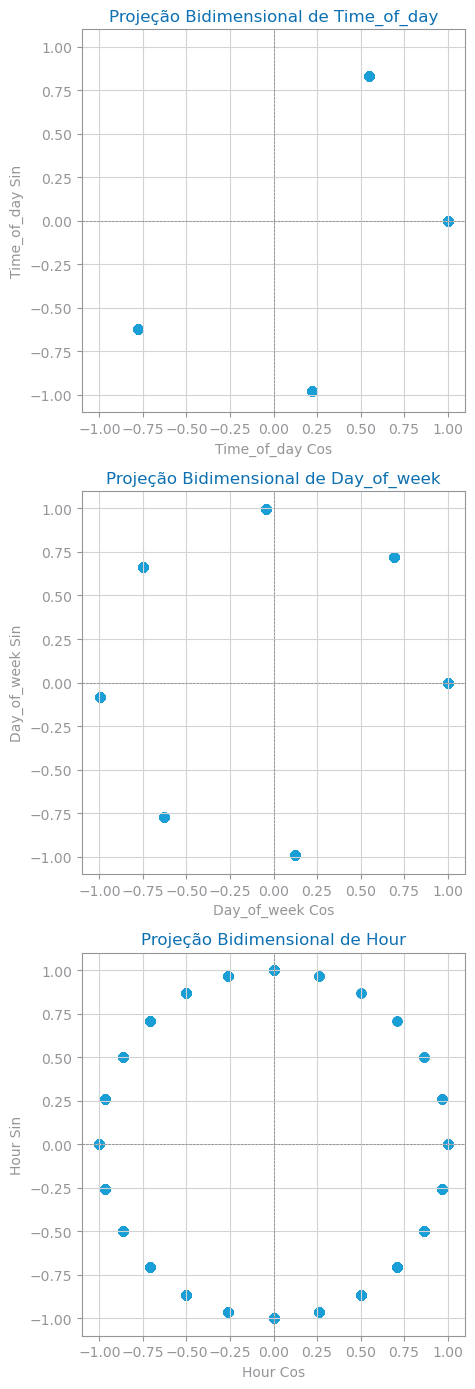

In [199]:
import matplotlib.pyplot as plt

# Lista de variáveis cíclicas
cyclical_vars = ['time_of_day', 'day_of_week', 'hour']

# Criar gráficos de dispersão para cada variável cíclica com tamanho maior
plt.figure(figsize=(14, 14))  # Aumentando o tamanho da figura

for i, var in enumerate(cyclical_vars):
    # Valores de seno e cosseno para a variável atual
    x_values = df_enc[f'{var}_cos']
    y_values = df_enc[f'{var}_sin']
    
    # Criar um subplot para cada variável
    plt.subplot(len(cyclical_vars), 1, i + 1)
    plt.scatter(x_values, y_values, alpha=0.6)
    plt.axhline(0, color='gray', lw=0.5, ls='--')
    plt.axvline(0, color='gray', lw=0.5, ls='--')
    
    # Ajustar os limites dos eixos para melhor visualização
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    
    # Adicionar título e rótulos
    plt.title(f'Projeção Bidimensional de {var.capitalize()}')
    plt.xlabel(f'{var.capitalize()} Cos')
    plt.ylabel(f'{var.capitalize()} Sin')
    
    # Mostrar a grade
    plt.grid()
    plt.gca().set_aspect('equal', adjustable='box')  # Para garantir que o gráfico é circular

plt.tight_layout()  # Ajustar o layout
plt.show()  # Mostrar todos os gráficos


In [324]:
df_enc.head()


,bike_type,user_type,start_borough,end_borough,day_of_month,is_weekend,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,wmo_weather_desc,ride_distance_km,ride_avg_speed,time_of_day_sin,time_of_day_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos
2312025,1,1,Manhattan,Manhattan,29,0,7.440667,28.1,0.1,22,7.3,Drizzle: Light,1.144934,9.232510,-0.975,0.221,0.721,0.693,-0.259,-0.966
2113099,0,1,Manhattan,Manhattan,4,0,13.555450,9.0,0.0,100,17.6,Overcast,1.963550,8.691190,-0.975,0.221,-0.081,-0.997,-0.707,-0.707
2275592,1,1,Brooklyn,Brooklyn,30,0,9.033033,19.9,0.0,2,11.3,Overcast,1.827167,12.136569,-0.975,0.221,0.999,-0.041,-0.866,-0.500
1041224,1,0,Brooklyn,Brooklyn,20,1,29.433967,18.0,0.0,2,11.9,Clear sky,3.347392,6.823530,-0.975,0.221,-0.993,0.121,0.000,-1.000
196201,1,1,Brooklyn,Manhattan,25,0,2.392867,6.0,0.0,0,8.3,Overcast,0.311617,7.813659,-0.624,-0.781,-0.081,-0.997,-0.866,0.500


## Dummyifcation enconding
- Apply dummyification method to the following variables:
    - start_borough
    - end_borough
    - wmo_weather_desc


In [325]:
# Apply one-hot encoding to the symbolic variables
df_enc = pd.get_dummies(df_enc, columns=["start_borough", "end_borough", "wmo_weather_desc"], dtype=int)


display(df_enc.head())

,bike_type,user_type,day_of_month,is_weekend,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,ride_distance_km,...,end_borough_Staten Island,wmo_weather_desc_Clear sky,wmo_weather_desc_Drizzle: Dense,wmo_weather_desc_Drizzle: Light,wmo_weather_desc_Drizzle: Moderate,wmo_weather_desc_Mainly clear,wmo_weather_desc_Overcast,wmo_weather_desc_Partly cloudy,wmo_weather_desc_Rain: Moderate,wmo_weather_desc_Rain: Slight
2312025,1,1,29,0,7.440667,28.1,0.1,22,7.3,1.144934,...,0,0,0,1,0,0,0,0,0,0
2113099,0,1,4,0,13.555450,9.0,0.0,100,17.6,1.963550,...,0,0,0,0,0,0,1,0,0,0
2275592,1,1,30,0,9.033033,19.9,0.0,2,11.3,1.827167,...,0,0,0,0,0,0,1,0,0,0
1041224,1,0,20,1,29.433967,18.0,0.0,2,11.9,3.347392,...,0,1,0,0,0,0,0,0,0,0
196201,1,1,25,0,2.392867,6.0,0.0,0,8.3,0.311617,...,0,0,0,0,0,0,1,0,0,0


In [326]:
df_enc.shape

(12774, 37)

In [327]:
df_enc.columns

Index(['bike_type', 'user_type', 'day_of_month', 'is_weekend',
       'ride_duration_min', 'temperature_2m', 'rain_mm', 'cloud_cover_low_pct',
       'wind_speed_10m', 'ride_distance_km', 'ride_avg_speed',
       'time_of_day_sin', 'time_of_day_cos', 'day_of_week_sin',
       'day_of_week_cos', 'hour_sin', 'hour_cos', 'start_borough_Bronx',
       'start_borough_Brooklyn', 'start_borough_Manhattan',
       'start_borough_Queens', 'start_borough_Staten Island',
       'end_borough_Bronx', 'end_borough_Brooklyn', 'end_borough_Jersey City',
       'end_borough_Manhattan', 'end_borough_Queens',
       'end_borough_Staten Island', 'wmo_weather_desc_Clear sky',
       'wmo_weather_desc_Drizzle: Dense', 'wmo_weather_desc_Drizzle: Light',
       'wmo_weather_desc_Drizzle: Moderate', 'wmo_weather_desc_Mainly clear',
       'wmo_weather_desc_Overcast', 'wmo_weather_desc_Partly cloudy',
       'wmo_weather_desc_Rain: Moderate', 'wmo_weather_desc_Rain: Slight'],
      dtype='object')

In [328]:
df_enc.head()

,bike_type,user_type,day_of_month,is_weekend,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,ride_distance_km,...,end_borough_Staten Island,wmo_weather_desc_Clear sky,wmo_weather_desc_Drizzle: Dense,wmo_weather_desc_Drizzle: Light,wmo_weather_desc_Drizzle: Moderate,wmo_weather_desc_Mainly clear,wmo_weather_desc_Overcast,wmo_weather_desc_Partly cloudy,wmo_weather_desc_Rain: Moderate,wmo_weather_desc_Rain: Slight
2312025,1,1,29,0,7.440667,28.1,0.1,22,7.3,1.144934,...,0,0,0,1,0,0,0,0,0,0
2113099,0,1,4,0,13.555450,9.0,0.0,100,17.6,1.963550,...,0,0,0,0,0,0,1,0,0,0
2275592,1,1,30,0,9.033033,19.9,0.0,2,11.3,1.827167,...,0,0,0,0,0,0,1,0,0,0
1041224,1,0,20,1,29.433967,18.0,0.0,2,11.9,3.347392,...,0,1,0,0,0,0,0,0,0,0
196201,1,1,25,0,2.392867,6.0,0.0,0,8.3,0.311617,...,0,0,0,0,0,0,1,0,0,0


# correlation matrix  after enconding

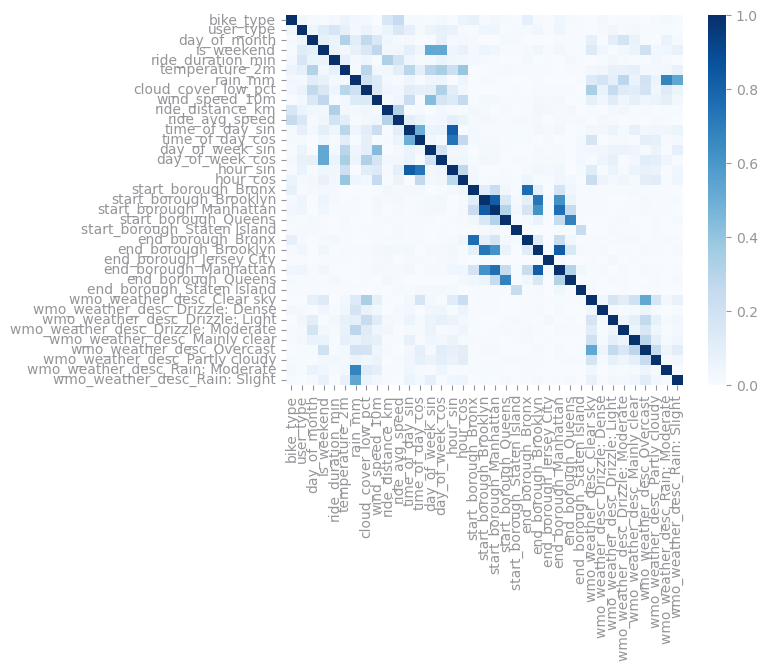

In [329]:
from seaborn import heatmap
from matplotlib.pyplot import figure, savefig, show

variables_types: dict[str, list] = get_variable_types(df_enc)
numeric: list[str] = variables_types["numeric"]
corr_mtx: DataFrame = df_enc.corr().abs()

figure()
heatmap(
    abs(corr_mtx),
    xticklabels=df_enc.columns,
    yticklabels=df_enc.columns,
    annot=False,
    cmap="Blues",
    vmin=0,
    vmax=1,
)
#savefig(f"images/{file_tag}_correlation_analysis.png")
show()

# Cluster Data Preparation
- To apply clustering thecniques we need to apply specific date preparation thecniques, like scaling, drop of outliers and also feature selection

## Drop Outliers

- using nr_stdev=2

In [330]:
from pandas import DataFrame, Series

# Usar a função get_variable_types() para obter as variáveis numéricas
variable_types: dict[str, list] = get_variable_types(df)
numeric: list[str] = variable_types["numeric"]


def apply_strategy_2(df: DataFrame, summary5: DataFrame, nr_stdev: float = 2) -> DataFrame:
    df_copy = df.copy()

    # Definindo as variáveis contínuas específicas que desejas monitorar


    # Filtrar apenas as variáveis contínuas que existem no DataFrame
    numeric_vars = [var for var in numeric if var in df_copy.columns]

    if numeric_vars:
        print(f"Data before dropping outliers with nr_stdev={nr_stdev}:", df_copy.shape)
        
        # Armazenar informações sobre os outliers
        outlier_info = {}

        for var in numeric_vars:
            # Calcular os limites de outlier para a variável usando o número de desvios padrão
            mean = summary5[var]['mean']
            std = summary5[var]['std']
            
            top = mean + nr_stdev * std
            bottom = mean - nr_stdev * std
            
            # Identificar os outliers
            outliers: Series = df_copy[(df_copy[var] > top) | (df_copy[var] < bottom)]
            
            # Se houver outliers, armazenar as informações
            if not outliers.empty:
                outlier_info[var] = {
                    'outlier_indices': outliers.index.tolist(),
                    'outlier_count': outliers.shape[0],
                    'outlier_values': outliers[var].tolist()
                }

                # Remover outliers
                df_copy.drop(outliers.index, axis=0, inplace=True)
        
        print(f"Data after dropping outliers with nr_stdev={nr_stdev}:", df_copy.shape)

        # Imprimir informações sobre os outliers removidos apenas para as variáveis com outliers
        if outlier_info:
            for var, info in outlier_info.items():
                print(f"Variable '{var}':")
                print(f"  Number of outliers removed: {info['outlier_count']}")
                print(f"  Indices of outliers: {info['outlier_indices']}")
                print(f"  Values of outliers: {info['outlier_values']}")
                print()  # Linha em branco para melhor legibilidade
        else:
            print("No outliers were removed.")
    else:
        print("There are no numeric variables")

    return df_copy

# Usar a função
summary5 = df.describe()  # Calcular o resumo estatístico apenas para as variáveis de interesse
nr_stdev = 2  # Exemplo, mas pode ser alterado para 3 ou outro valor

df_prep_outl = apply_strategy_2(df_enc, summary5, nr_stdev)


Data before dropping outliers with nr_stdev=2: (12774, 37)
Data after dropping outliers with nr_stdev=2: (9384, 37)
Variable 'ride_duration_min':
  Number of outliers removed: 220
  Indices of outliers: [1764348, 2045121, 346591, 2917805, 1554068, 110312, 921264, 1134506, 1861081, 1076052, 582773, 1398895, 1829445, 2376455, 2410918, 1997412, 1378569, 2671870, 1123266, 2521236, 1524770, 1092485, 1209349, 127844, 2037680, 1722757, 1279234, 2138236, 2069852, 724055, 558386, 95674, 2481552, 2105126, 2597020, 1526351, 2713967, 399280, 1248473, 872357, 2464533, 1512484, 2694240, 1789284, 83229, 3085870, 2477741, 1996345, 650272, 2264171, 2405958, 2870762, 294214, 899375, 1505454, 1517619, 171629, 2263177, 1606803, 2233252, 1159331, 1999463, 2852479, 2944420, 2869960, 926124, 1245389, 2287663, 3173458, 2316911, 2657484, 969733, 2654185, 13211, 1428316, 968292, 2014591, 1083566, 318407, 2491021, 1760415, 2407730, 1628634, 1794800, 549236, 295622, 2380483, 427119, 2672104, 882076, 2603968, 6120

In [331]:
df_prep_outl.shape

(9384, 37)

In [332]:
df_prep_outl.columns

Index(['bike_type', 'user_type', 'day_of_month', 'is_weekend',
       'ride_duration_min', 'temperature_2m', 'rain_mm', 'cloud_cover_low_pct',
       'wind_speed_10m', 'ride_distance_km', 'ride_avg_speed',
       'time_of_day_sin', 'time_of_day_cos', 'day_of_week_sin',
       'day_of_week_cos', 'hour_sin', 'hour_cos', 'start_borough_Bronx',
       'start_borough_Brooklyn', 'start_borough_Manhattan',
       'start_borough_Queens', 'start_borough_Staten Island',
       'end_borough_Bronx', 'end_borough_Brooklyn', 'end_borough_Jersey City',
       'end_borough_Manhattan', 'end_borough_Queens',
       'end_borough_Staten Island', 'wmo_weather_desc_Clear sky',
       'wmo_weather_desc_Drizzle: Dense', 'wmo_weather_desc_Drizzle: Light',
       'wmo_weather_desc_Drizzle: Moderate', 'wmo_weather_desc_Mainly clear',
       'wmo_weather_desc_Overcast', 'wmo_weather_desc_Partly cloudy',
       'wmo_weather_desc_Rain: Moderate', 'wmo_weather_desc_Rain: Slight'],
      dtype='object')

In [333]:
display(df.shape) # original df
display(df_enc.shape) # df after enconding
display(df_prep_outl.shape) # df after enconding and data prep outlier removal


(12774, 17)

(12774, 37)

(9384, 37)

In [334]:
df_enc.head()

,bike_type,user_type,day_of_month,is_weekend,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,ride_distance_km,...,end_borough_Staten Island,wmo_weather_desc_Clear sky,wmo_weather_desc_Drizzle: Dense,wmo_weather_desc_Drizzle: Light,wmo_weather_desc_Drizzle: Moderate,wmo_weather_desc_Mainly clear,wmo_weather_desc_Overcast,wmo_weather_desc_Partly cloudy,wmo_weather_desc_Rain: Moderate,wmo_weather_desc_Rain: Slight
2312025,1,1,29,0,7.440667,28.1,0.1,22,7.3,1.144934,...,0,0,0,1,0,0,0,0,0,0
2113099,0,1,4,0,13.555450,9.0,0.0,100,17.6,1.963550,...,0,0,0,0,0,0,1,0,0,0
2275592,1,1,30,0,9.033033,19.9,0.0,2,11.3,1.827167,...,0,0,0,0,0,0,1,0,0,0
1041224,1,0,20,1,29.433967,18.0,0.0,2,11.9,3.347392,...,0,1,0,0,0,0,0,0,0,0
196201,1,1,25,0,2.392867,6.0,0.0,0,8.3,0.311617,...,0,0,0,0,0,0,1,0,0,0


## Scaling

### Scale strategy 1 - Standard Scaler

In [336]:
# Escolher o DataFrame a ser utilizado no scaling com base na variável 'use_df_scaling'
if use_df_in_scaling == "df_enc":
    df_to_use_scal = df_enc
elif use_df_in_scaling == "df_prep_outl":
    df_to_use_scal = df_prep_outl  # Presumo que df_prep_outl seja o outro DataFrame desejado
else:
    raise ValueError(f"Invalid DataFrame choice: {use_df_in_scaling}. Choose either 'df_enc' or 'df_prep_outl'.")

# Exibir qual DataFrame foi escolhido
print(f"We will use the {use_df_in_scaling} dataset, which means that we are {'not ' if use_df_in_scaling == 'df_enc' else ''}considering the removal of outliers.")
print(f"Shape of dataset: {df_to_use_scal.shape}")


We will use the df_prep_outl dataset, which means that we are considering the removal of outliers.
Shape of dataset: (9384, 37)


In [337]:

from sklearn.preprocessing import StandardScaler
from pandas import DataFrame

def apply_standard_scaler(df: DataFrame) -> DataFrame:

    df_copy = df.copy()
    
    # Apply scaling to all the feature columns (since there is no target)
    transf: StandardScaler = StandardScaler(with_mean=True, with_std=True, copy=True).fit(df_copy)
    df_zscore = DataFrame(transf.transform(df_copy), index=df_copy.index, columns=df_copy.columns)
    
    return df_zscore

In [338]:

def apply_strategy_1(df):

    df_copy=df.copy()
    
    df_zscore=apply_standard_scaler(df_copy)

    return df_zscore

df_prep_scal=apply_strategy_1(df_to_use_scal)

df_prep_scal.columns

Index(['bike_type', 'user_type', 'day_of_month', 'is_weekend',
       'ride_duration_min', 'temperature_2m', 'rain_mm', 'cloud_cover_low_pct',
       'wind_speed_10m', 'ride_distance_km', 'ride_avg_speed',
       'time_of_day_sin', 'time_of_day_cos', 'day_of_week_sin',
       'day_of_week_cos', 'hour_sin', 'hour_cos', 'start_borough_Bronx',
       'start_borough_Brooklyn', 'start_borough_Manhattan',
       'start_borough_Queens', 'start_borough_Staten Island',
       'end_borough_Bronx', 'end_borough_Brooklyn', 'end_borough_Jersey City',
       'end_borough_Manhattan', 'end_borough_Queens',
       'end_borough_Staten Island', 'wmo_weather_desc_Clear sky',
       'wmo_weather_desc_Drizzle: Dense', 'wmo_weather_desc_Drizzle: Light',
       'wmo_weather_desc_Drizzle: Moderate', 'wmo_weather_desc_Mainly clear',
       'wmo_weather_desc_Overcast', 'wmo_weather_desc_Partly cloudy',
       'wmo_weather_desc_Rain: Moderate', 'wmo_weather_desc_Rain: Slight'],
      dtype='object')

In [111]:
df_prep_scal.info()


<class 'pandas.core.frame.DataFrame'>
Index: 9487 entries, 1002305 to 2068944
Data columns (total 37 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   bike_type                           9487 non-null   float64
 1   user_type                           9487 non-null   float64
 2   day_of_month                        9487 non-null   float64
 3   is_weekend                          9487 non-null   float64
 4   ride_duration_min                   9487 non-null   float64
 5   temperature_2m                      9487 non-null   float64
 6   rain_mm                             9487 non-null   float64
 7   cloud_cover_low_pct                 9487 non-null   float64
 8   wind_speed_10m                      9487 non-null   float64
 9   ride_distance_km                    9487 non-null   float64
 10  ride_avg_speed                      9487 non-null   float64
 11  time_of_day_sin                     948

In [339]:
df_prep_scal.shape

(9384, 37)

In [340]:
display(df_prep_scal['bike_type'].value_counts())
display(df_prep_scal['user_type'].value_counts())

bike_type
 0.749091    6011
-1.334951    3373
Name: count, dtype: int64

user_type
 0.485502    7594
-2.059723    1790
Name: count, dtype: int64

### Scale strategy 2 - MinMax Scaler


In [341]:
from sklearn.preprocessing import MinMaxScaler

def apply_min_max_scaler(df: DataFrame) -> DataFrame:

    df_copy=df.copy()
        # Apply MinMax scaling to the feature columns only
    transf: MinMaxScaler = MinMaxScaler(feature_range=(0, 1), copy=True).fit(df_copy)
    df_minmax = DataFrame(transf.transform(df_copy), index=df_copy.index, columns=df_copy.columns)
    
    return df_minmax

In [342]:
from pandas import DataFrame, Series
from sklearn.preprocessing import MinMaxScaler


def apply_strategy_2(df):

    df_copy=df.copy()
    
    # this script is available in data_functions originally from DSLabs site in Scaling chapter
    df_copy=apply_min_max_scaler(df)

    return df_copy

df_pre_scal_2=apply_strategy_2(df_to_use_scal)
df_pre_scal_2.columns

Index(['bike_type', 'user_type', 'day_of_month', 'is_weekend',
       'ride_duration_min', 'temperature_2m', 'rain_mm', 'cloud_cover_low_pct',
       'wind_speed_10m', 'ride_distance_km', 'ride_avg_speed',
       'time_of_day_sin', 'time_of_day_cos', 'day_of_week_sin',
       'day_of_week_cos', 'hour_sin', 'hour_cos', 'start_borough_Bronx',
       'start_borough_Brooklyn', 'start_borough_Manhattan',
       'start_borough_Queens', 'start_borough_Staten Island',
       'end_borough_Bronx', 'end_borough_Brooklyn', 'end_borough_Jersey City',
       'end_borough_Manhattan', 'end_borough_Queens',
       'end_borough_Staten Island', 'wmo_weather_desc_Clear sky',
       'wmo_weather_desc_Drizzle: Dense', 'wmo_weather_desc_Drizzle: Light',
       'wmo_weather_desc_Drizzle: Moderate', 'wmo_weather_desc_Mainly clear',
       'wmo_weather_desc_Overcast', 'wmo_weather_desc_Partly cloudy',
       'wmo_weather_desc_Rain: Moderate', 'wmo_weather_desc_Rain: Slight'],
      dtype='object')

In [220]:
df_pre_scal_2.shape

(9195, 36)

#### scaling plot - visualize oth streategies

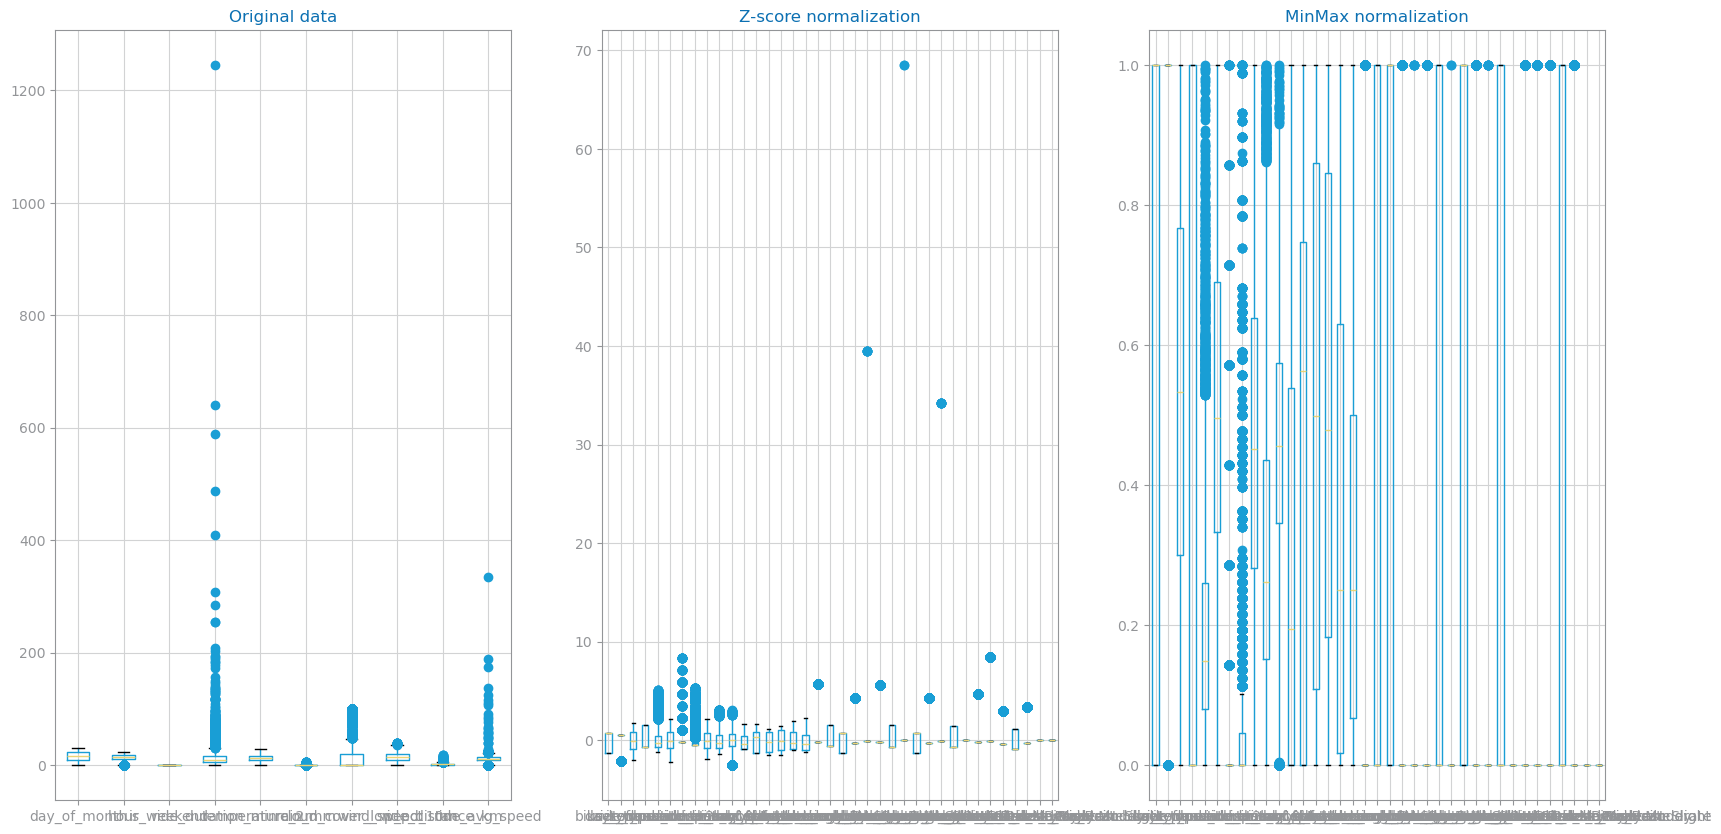

In [343]:
from matplotlib.pyplot import subplots, show

fig, axs = subplots(1, 3, figsize=(20, 10), squeeze=False)
axs[0, 0].set_title("Original data")
df.boxplot(ax=axs[0, 0])
axs[0, 1].set_title("Z-score normalization")
df_prep_scal.boxplot(ax=axs[0, 1])
axs[0, 2].set_title("MinMax normalization")
df_pre_scal_2.boxplot(ax=axs[0, 2])
show()

## Feature selection

### Feat 2 - Variance Threshold (Remove Low-Variance Features)


In [344]:

# Escolher o DataFrame a ser utilizado com base na variável 'use_df_in_feat_eng' (feature engineering)
if use_df_in_feat_eng == "df_enc":
    df_to_use_feat = df_enc
elif use_df_in_feat_eng == "df_prep_outl":
    df_to_use_feat = df_prep_outl
elif use_df_in_feat_eng == "df_prep_scal":
    df_to_use_feat = df_prep_scal
else:
    raise ValueError(f"Invalid DataFrame choice: {use_df_in_feat_eng}. Choose either 'df_enc' or 'df_prep_outl'.")

# Exibir qual DataFrame foi escolhido
print(f"We will use the dataset {use_df_in_feat_eng} dataset, which means that we are {'not ' if use_df_in_feat_eng == 'df_enc' else ''}considering the removal of outliers and also scaled data")
print(f"Shape of dataset: {df_to_use_feat.shape}")


We will use the dataset df_prep_scal dataset, which means that we are considering the removal of outliers and also scaled data
Shape of dataset: (9384, 37)


In [223]:
display(df.shape) # original df
display(df_enc.shape) # df after enconding
display(df_prep_outl.shape) # df after enconding and data prep outlier removal

(12774, 17)

(12774, 36)

(9195, 36)

In [351]:
from sklearn.feature_selection import VarianceThreshold

# Remove features with very low variance
selector = VarianceThreshold(threshold=0.1)  # Ajuste o threshold conforme necessário
X_reduced = selector.fit_transform(df_to_use_feat)

# Get selected features
selected_features = df_to_use_feat.columns[selector.get_support()]
print(selected_features)

Index(['bike_type', 'user_type', 'day_of_month', 'is_weekend',
       'ride_duration_min', 'temperature_2m', 'rain_mm', 'cloud_cover_low_pct',
       'wind_speed_10m', 'ride_distance_km', 'ride_avg_speed',
       'time_of_day_sin', 'time_of_day_cos', 'day_of_week_sin',
       'day_of_week_cos', 'hour_sin', 'hour_cos', 'start_borough_Bronx',
       'start_borough_Brooklyn', 'start_borough_Manhattan',
       'start_borough_Queens', 'start_borough_Staten Island',
       'end_borough_Bronx', 'end_borough_Brooklyn', 'end_borough_Jersey City',
       'end_borough_Manhattan', 'end_borough_Queens',
       'end_borough_Staten Island', 'wmo_weather_desc_Clear sky',
       'wmo_weather_desc_Drizzle: Light', 'wmo_weather_desc_Drizzle: Moderate',
       'wmo_weather_desc_Mainly clear', 'wmo_weather_desc_Overcast',
       'wmo_weather_desc_Partly cloudy'],
      dtype='object')


In [352]:
import pandas as pd
from sklearn.feature_selection import VarianceThreshold


# Print initial features
print("Initial features:\n", df_to_use_feat.columns.tolist())

# Compute variance for each feature
feature_variance = df_to_use_feat.var()
print("\nFeature Variance:\n", feature_variance)

# Define threshold (adjust based on the dataset)
threshold = 0.1
selector = VarianceThreshold(threshold=threshold)

# Fit and transform the dataset
X_reduced = selector.fit_transform(df_to_use_feat)

# Get selected features
initial_features = list(set(df_to_use_feat.columns))
removed_features = list(set(df_to_use_feat.columns) - set(selected_features))
selected_features = df_to_use_feat.columns[selector.get_support()]


# Print results
print("Initial Features df_prep:\n", initial_features)
print("\nRemoved Features (low variance < {:.3f}):\n".format(threshold), removed_features)
print("\nFinal Features list:\n", selected_features.tolist())


Initial features:
 ['bike_type', 'user_type', 'day_of_month', 'is_weekend', 'ride_duration_min', 'temperature_2m', 'rain_mm', 'cloud_cover_low_pct', 'wind_speed_10m', 'ride_distance_km', 'ride_avg_speed', 'time_of_day_sin', 'time_of_day_cos', 'day_of_week_sin', 'day_of_week_cos', 'hour_sin', 'hour_cos', 'start_borough_Bronx', 'start_borough_Brooklyn', 'start_borough_Manhattan', 'start_borough_Queens', 'start_borough_Staten Island', 'end_borough_Bronx', 'end_borough_Brooklyn', 'end_borough_Jersey City', 'end_borough_Manhattan', 'end_borough_Queens', 'end_borough_Staten Island', 'wmo_weather_desc_Clear sky', 'wmo_weather_desc_Drizzle: Dense', 'wmo_weather_desc_Drizzle: Light', 'wmo_weather_desc_Drizzle: Moderate', 'wmo_weather_desc_Mainly clear', 'wmo_weather_desc_Overcast', 'wmo_weather_desc_Partly cloudy', 'wmo_weather_desc_Rain: Moderate', 'wmo_weather_desc_Rain: Slight']

Feature Variance:
 bike_type                             1.000107
user_type                             1.000107


In [353]:
df_prep_feat_var = df_to_use_feat[selected_features]

### Feat 3 - Drop Redundant Variables
    - Correlation interpretation - values between [-1,1]:
        - 0.9 and above: Very strong correlation (typically, > 0.9 is considered almost perfect).
        - 0.7 to 0.9: Strong correlation.
        - 0.3 to 0.7: Moderate correlation.
        - 0.1 to 0.3: Weak correlation.
        - 0 to 0.1: No significant correlation.       

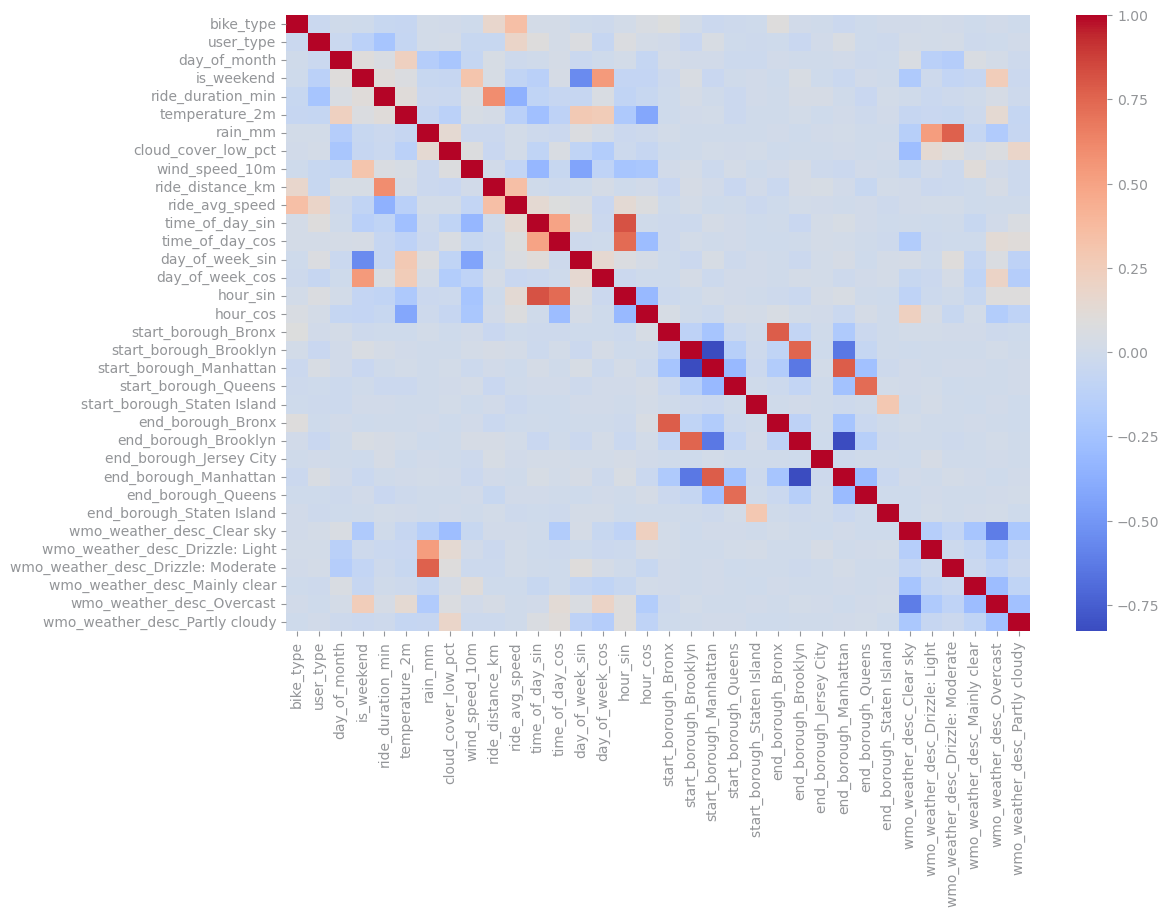

In [354]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = df_prep_feat_var.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False)
plt.show()

In [355]:
import numpy as np

# Calculate correlation matrix
corr_matrix = df_prep_feat_var.corr()

# Identify pairs of highly correlated features (correlation > 0.8)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Initialize an empty list to store the pairs of highly correlated features
redundant_pairs = []

# Loop through each column to find pairs with correlation > 0.8
for column in upper_tri.columns:
    for row in upper_tri.index:
        if upper_tri.loc[row, column] > 0.7:
            redundant_pairs.append((row, column, upper_tri.loc[row, column]))

# Print initial features count
print(f"Initial number of features: {len(df_prep_feat_var.columns)}")

# Print redundant pairs
print(f"Redundant pairs (correlation > 0.8):")
for pair in redundant_pairs:
    print(f"{pair[0]} and {pair[1]}: Correlation = {pair[2]}")

# Identify the features to drop based on redundancy
to_drop = [pair[1] for pair in redundant_pairs]

# Print features that will be dropped
print(f"Number of features dropped: {len(to_drop)}")
print(f"Features dropped: {to_drop}")

# Drop the correlated features
df_prep_feat = df_prep_feat_var.drop(columns=to_drop)

# Print remaining features count
print(f"Remaining features: {len(df_prep_feat.columns)}")
print(f"Remaining features: {df_prep_feat.columns.tolist()}")


Initial number of features: 34
Redundant pairs (correlation > 0.8):
time_of_day_sin and hour_sin: Correlation = 0.8188442321612941
time_of_day_cos and hour_sin: Correlation = 0.7323257504664901
start_borough_Bronx and end_borough_Bronx: Correlation = 0.7822700242173629
start_borough_Brooklyn and end_borough_Brooklyn: Correlation = 0.7551710829350559
start_borough_Manhattan and end_borough_Manhattan: Correlation = 0.7817211244829524
start_borough_Queens and end_borough_Queens: Correlation = 0.72819414181211
rain_mm and wmo_weather_desc_Drizzle: Moderate: Correlation = 0.7709221882266463
Number of features dropped: 7
Features dropped: ['hour_sin', 'hour_sin', 'end_borough_Bronx', 'end_borough_Brooklyn', 'end_borough_Manhattan', 'end_borough_Queens', 'wmo_weather_desc_Drizzle: Moderate']
Remaining features: 28
Remaining features: ['bike_type', 'user_type', 'day_of_month', 'is_weekend', 'ride_duration_min', 'temperature_2m', 'rain_mm', 'cloud_cover_low_pct', 'wind_speed_10m', 'ride_distanc

In [356]:
display(df.shape) # original df
display(df_enc.shape) # df after enconding
display(df_prep_outl.shape) # df after enconding and data prep outlier removal
display(df_prep_feat_var.shape) 
display(df_prep_feat.shape) 

(12774, 17)

(12774, 37)

(9384, 37)

(9384, 34)

(9384, 28)

# Cluster Application Techinques 

In [357]:

# Escolher o DataFrame a ser utilizado com base na variável 'use_df_in_clust' (clustering)
if use_df_in_clust == "df_enc":
    df_to_use_clust = df_enc
elif use_df_in_clust == "df_prep_outl":
    df_to_use_clust = df_prep_outl
elif use_df_in_clust == "df_prep_scal":
    df_to_use_clust = df_prep_scal
elif use_df_in_clust == "df_prep_feat":
    df_to_use_clust = df_prep_feat
else:
    raise ValueError(f"Invalid DataFrame choice: {use_df_in_clust}. Choose either 'df_enc' or 'df_prep_outl'.")

# Exibir qual DataFrame foi escolhido
print(f"We will use the dataset {use_df_in_clust} dataset, which means that we are {'not ' if use_df_in_clust == 'df_enc' else ''}considering the removal of outliers and also scaled data, and also removal of non relevant features")
print(f"Shape of dataset: {df_to_use_clust.shape}")

We will use the dataset df_prep_feat dataset, which means that we are considering the removal of outliers and also scaled data, and also removal of non relevant features
Shape of dataset: (9384, 28)


In [358]:
df_to_use_clust.head()

,bike_type,user_type,day_of_month,is_weekend,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,ride_distance_km,...,start_borough_Manhattan,start_borough_Queens,start_borough_Staten Island,end_borough_Jersey City,end_borough_Staten Island,wmo_weather_desc_Clear sky,wmo_weather_desc_Drizzle: Light,wmo_weather_desc_Mainly clear,wmo_weather_desc_Overcast,wmo_weather_desc_Partly cloudy
2275592,0.749091,0.485502,1.587598,-0.659940,-0.231809,1.388599,-0.209668,-0.309892,-0.532121,0.064925,...,-1.312390,-0.235477,-0.025294,-0.0146,-0.02921,-0.702872,-0.212654,-0.331871,1.142899,-0.293661
1041224,0.749091,-2.059723,0.344719,1.515289,2.271978,0.994829,-0.209668,-0.309892,-0.442361,1.314548,...,-1.312390,-0.235477,-0.025294,-0.0146,-0.02921,1.422733,-0.212654,-0.331871,-0.874968,-0.293661
196201,0.749091,0.485502,0.966158,-0.659940,-1.046750,-1.492139,-0.209668,-0.439330,-0.980918,-1.180854,...,-1.312390,-0.235477,-0.025294,-0.0146,-0.02921,-0.702872,-0.212654,-0.331871,1.142899,-0.293661
2253083,-1.334951,0.485502,0.220431,-0.659940,-0.599747,-0.186481,-0.209668,-0.309892,0.724511,-0.623092,...,0.761969,-0.235477,-0.025294,-0.0146,-0.02921,-0.702872,-0.212654,-0.331871,1.142899,-0.293661
2539636,0.749091,0.485502,0.469007,1.515289,-0.600775,-1.637212,-0.209668,-0.439330,-0.891159,-0.049651,...,0.761969,-0.235477,-0.025294,-0.0146,-0.02921,-0.702872,-0.212654,-0.331871,1.142899,-0.293661


## K means Clustering

### Elbow method study

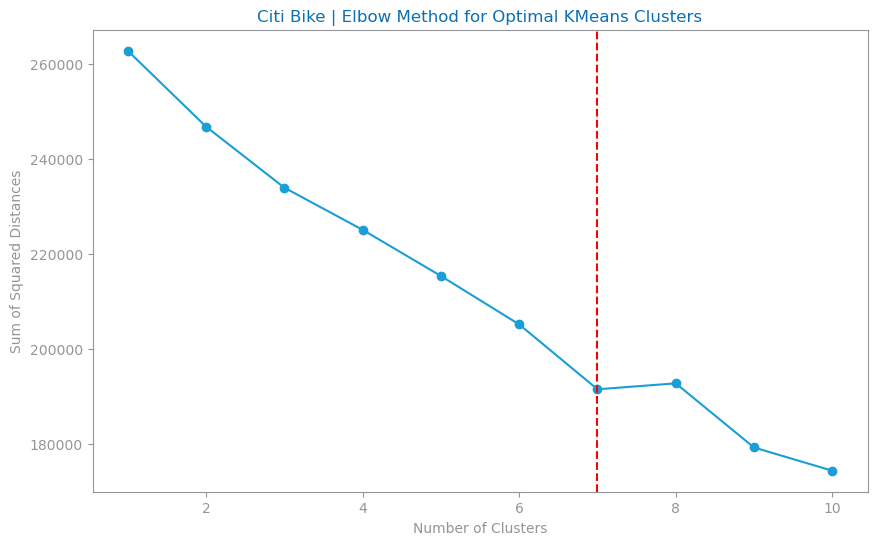

In [359]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from kneed import KneeLocator

# Define the range of clusters to evaluate
range_n_clusters = list(range(1, 11))

# Initialize an empty list to store the sum of squared distances
ssd = []

# Loop over the range of clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(df_to_use_clust)
    ssd.append(kmeans.inertia_)

# Determine the elbow point using KneeLocator
kneedle = KneeLocator(range_n_clusters, ssd, curve='convex', direction='decreasing')
elbow_point = kneedle.elbow

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, ssd, marker='o')
plt.title(f'{file_tag} | Elbow Method for Optimal KMeans Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')

# Add a vertical line at the elbow point
plt.axvline(x=elbow_point, color='r', linestyle='--')

plt.show()

### Sillhouete study for kmeans

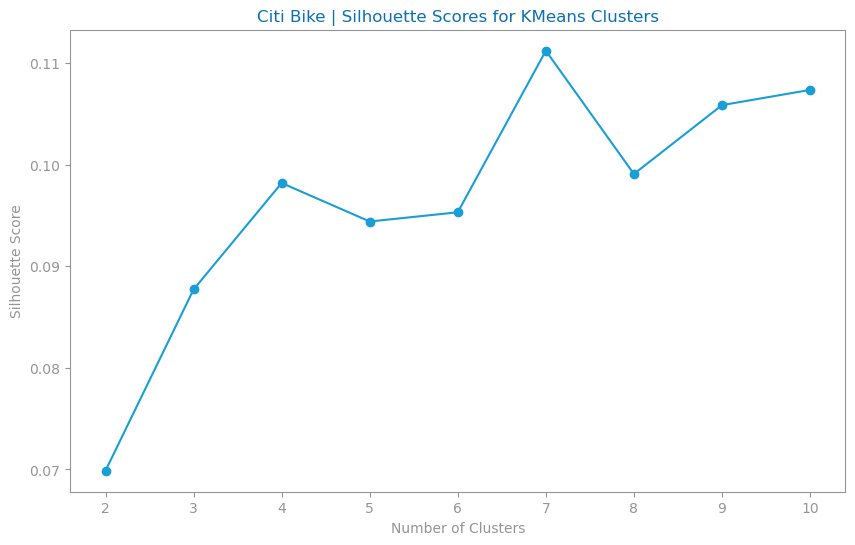

In [360]:
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt

# Define the range of clusters to evaluate
range_n_clusters = list(range(2, 11))

# Initialize an empty list to store the silhouette scores
silhouette_scores = []

# Loop over the range of clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(df_to_use_clust)
    silhouette_avg = silhouette_score(df_to_use_clust, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title(f'{file_tag} | Silhouette Scores for KMeans Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

## Kmeans model

In [375]:
# Clustering
citibike_kmeans = KMeans(n_clusters=2, random_state=42)
citibike_y_pred_kmeans = citibike_kmeans.fit_predict(df_to_use_clust)

citibike_kmeans.cluster_centers_

array([[-0.04523391, -0.0974678 ,  0.11482575,  0.55042951,  0.13101203,
         0.39155726, -0.20966823,  0.00209563,  0.18956407,  0.05203346,
        -0.11157191, -0.05547653,  0.20882633, -0.14761661,  0.34633524,
        -0.45629331, -0.02654487,  0.04611149, -0.02708034, -0.01393725,
        -0.00513617,  0.00285314,  0.0057081 , -0.62542995, -0.21265383,
        -0.21170354,  0.93005886, -0.17114819],
       [ 0.03252301,  0.07007897, -0.08255927, -0.3957567 , -0.09419715,
        -0.28152817,  0.15075065, -0.00150675, -0.13629584, -0.03741185,
         0.08021978,  0.03988741, -0.15014533,  0.10613578, -0.24901371,
         0.32807313,  0.01908566, -0.03315398,  0.01947066,  0.01002083,
         0.00369288, -0.0020514 , -0.00410411,  0.44968173,  0.15289729,
         0.15221403, -0.66870874,  0.12305489]])

## Hierarchical Clustering - Agglomerative

## Sillouette Study for Agglomerative

In [364]:
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

def evaluate_agglomerative_clustering(X, 
                                      n_clusters_list=[2, 3, 4, 5,6,7,8,9,10], 
                                      metric_list=['euclidean', 'manhattan', 'cosine'], 
                                      linkage_list=['ward', 'complete', 'average', 'single'],
                                      scale='no',
                                      title='Silhouette Scores for Different Clustering Parameters'):
    # Scale the data if required
    if scale == 'yes':
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

    # Store the results
    results = []

    for n_clusters in n_clusters_list:
        for metric in metric_list:
            for linkage in linkage_list:
                if linkage == 'ward' and metric != 'euclidean':
                    continue  # Ward linkage only works with Euclidean distance
                clustering = AgglomerativeClustering(n_clusters=n_clusters, metric=metric, linkage=linkage)
                labels = clustering.fit_predict(X)
                score = silhouette_score(X, labels)
                results.append((n_clusters, metric, linkage, score))

    # Convert results to a structured array for easy plotting
    dtype = [('n_clusters', int), ('metric', 'U10'), ('linkage', 'U10'), ('score', float)]
    results = np.array(results, dtype=dtype)

    # Plot the results
    fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharex=True)
    axes = axes.flatten()
    
    for ax, linkage in zip(axes, linkage_list):
        for metric in metric_list:
            subset = results[(results['metric'] == metric) & (results['linkage'] == linkage)]
            ax.plot(subset['n_clusters'], subset['score'], label=f'{metric}')
            for (n_clusters, score) in zip(subset['n_clusters'], subset['score']):
                ax.text(n_clusters, score, f'{score:.2f}', fontsize=8, ha='right')
        
        ax.set_title(f'Linkage: {linkage}')
        ax.set_xlabel('Number of Clusters')
        ax.set_ylabel('Silhouette Score')
        ax.legend(loc='upper right')
        ax.set_xticks(n_clusters_list)
        ax.set_xticklabels([str(n) for n in n_clusters_list])
    
    fig.suptitle(title, fontsize=16)
    plt.show()

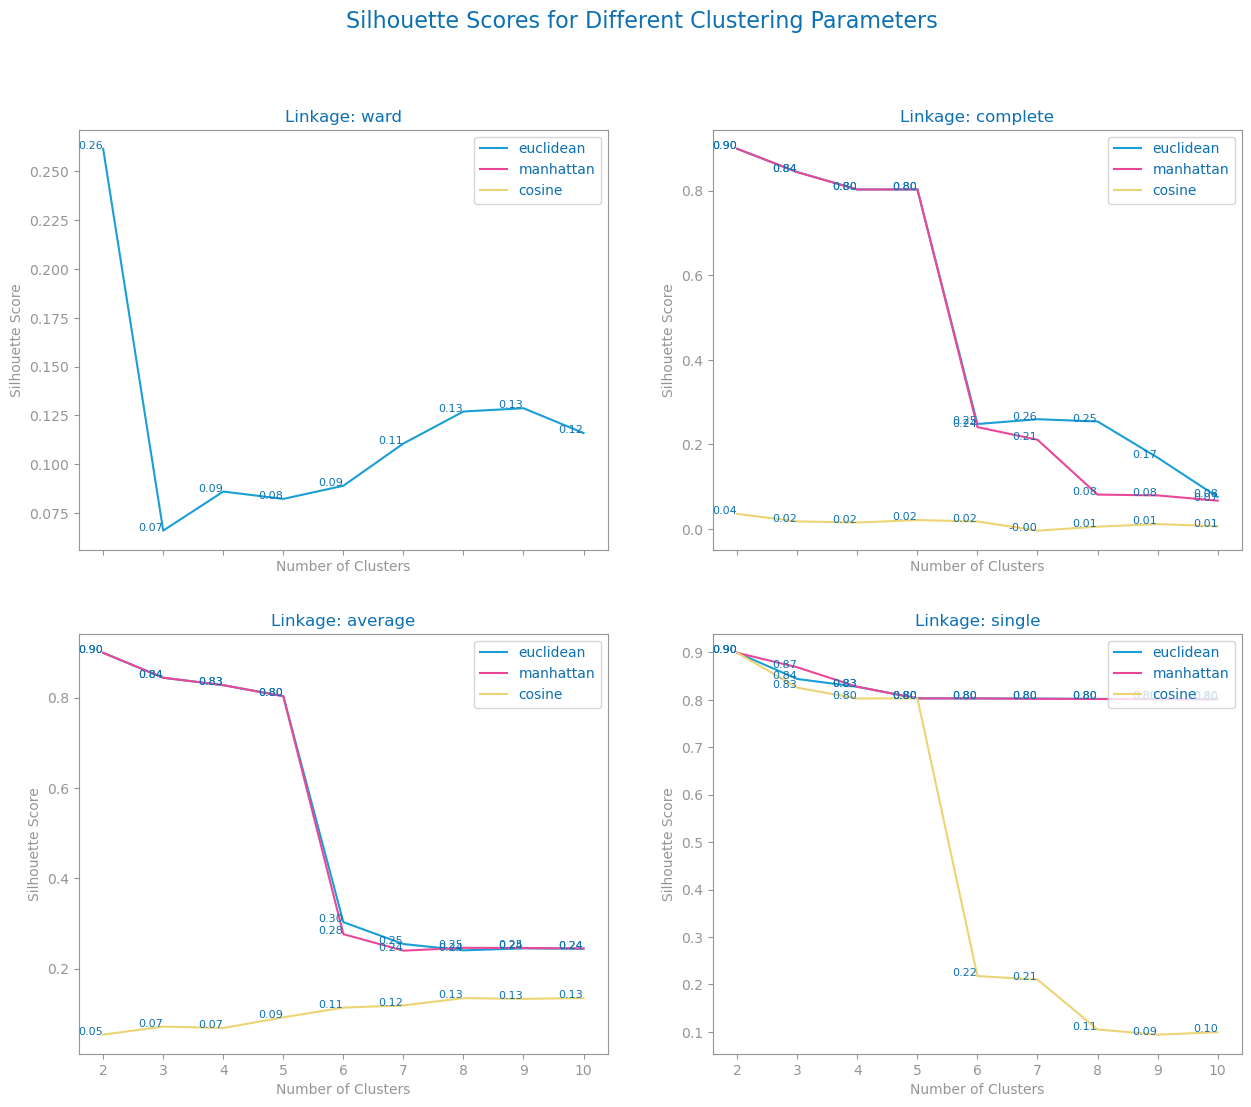

In [365]:
# available in data functions py

evaluate_agglomerative_clustering(df_to_use_clust, n_clusters_list=[2, 3, 4, 5,6,7,8,9,10], scale='no')

## Dendrogram

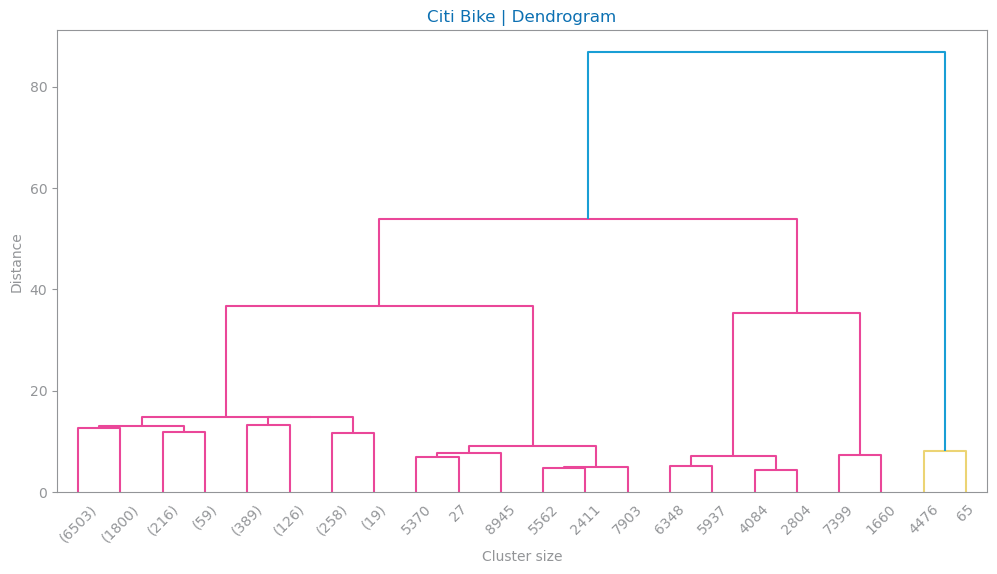

In [370]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Generate the linkage matrix
Z = linkage(df_to_use_clust, method='complete', metric='euclidean')

# Plot the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='level', p=5, leaf_rotation=45., leaf_font_size=10., count_sort='descending', distance_sort = 'descending'), 
plt.title(f'{file_tag} | Dendrogram')
plt.xlabel('Cluster size')
plt.ylabel('Distance')
plt.show()


## Agglomerative Model

In [373]:
from sklearn.cluster import AgglomerativeClustering

citibike_agglo = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='average' )
citibike_y_pred_agglo = citibike_agglo.fit_predict(df_to_use_clust)

citibike_y_pred_agglo

array([0, 0, 0, ..., 0, 0, 0])

## DBSCAN Clustering - density-based

In [383]:
df_to_use_clust.head()

,bike_type,user_type,day_of_month,is_weekend,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,ride_distance_km,...,end_borough_Jersey City,end_borough_Staten Island,wmo_weather_desc_Clear sky,wmo_weather_desc_Drizzle: Light,wmo_weather_desc_Mainly clear,wmo_weather_desc_Overcast,wmo_weather_desc_Partly cloudy,kmeans_cluster,agglo_cluster,cluster
2275592,0.749091,0.485502,1.587598,-0.659940,-0.231809,1.388599,-0.209668,-0.309892,-0.532121,0.064925,...,-0.0146,-0.02921,-0.702872,-0.212654,-0.331871,1.142899,-0.293661,0,0,-1
1041224,0.749091,-2.059723,0.344719,1.515289,2.271978,0.994829,-0.209668,-0.309892,-0.442361,1.314548,...,-0.0146,-0.02921,1.422733,-0.212654,-0.331871,-0.874968,-0.293661,0,0,-1
196201,0.749091,0.485502,0.966158,-0.659940,-1.046750,-1.492139,-0.209668,-0.439330,-0.980918,-1.180854,...,-0.0146,-0.02921,-0.702872,-0.212654,-0.331871,1.142899,-0.293661,1,0,-1
2253083,-1.334951,0.485502,0.220431,-0.659940,-0.599747,-0.186481,-0.209668,-0.309892,0.724511,-0.623092,...,-0.0146,-0.02921,-0.702872,-0.212654,-0.331871,1.142899,-0.293661,0,0,-1
2539636,0.749091,0.485502,0.469007,1.515289,-0.600775,-1.637212,-0.209668,-0.439330,-0.891159,-0.049651,...,-0.0146,-0.02921,-0.702872,-0.212654,-0.331871,1.142899,-0.293661,0,0,-1


In [384]:
df_to_use_clust.shape

(9384, 31)

Clusters identificados: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, -1}


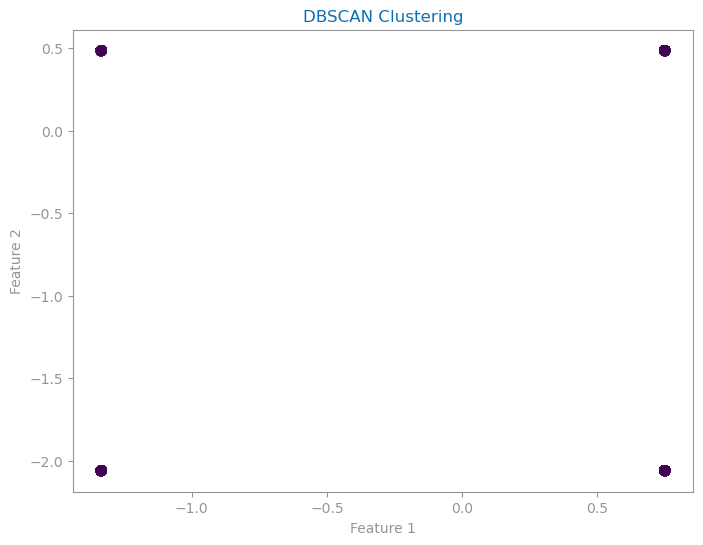

In [387]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Tentar valores diferentes para eps e min_samples
eps = 2        # Aumente este valor para aumentar a distância máxima entre pontos no mesmo cluster
min_samples = 10  # Experimente diminuir este valor para formar clusters menores

# Aplicar DBSCAN ao DataFrame
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
df_to_use_clust['cluster'] = dbscan.fit_predict(df_to_use_clust)

# Exibir os resultados
print("Clusters identificados:", set(df_to_use_clust['cluster']))

# Plotar os resultados
plt.figure(figsize=(8, 6))
plt.scatter(df_to_use_clust.iloc[:, 0], df_to_use_clust.iloc[:, 1], c=df_to_use_clust['cluster'], cmap='viridis', s=50)
plt.title('DBSCAN Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()



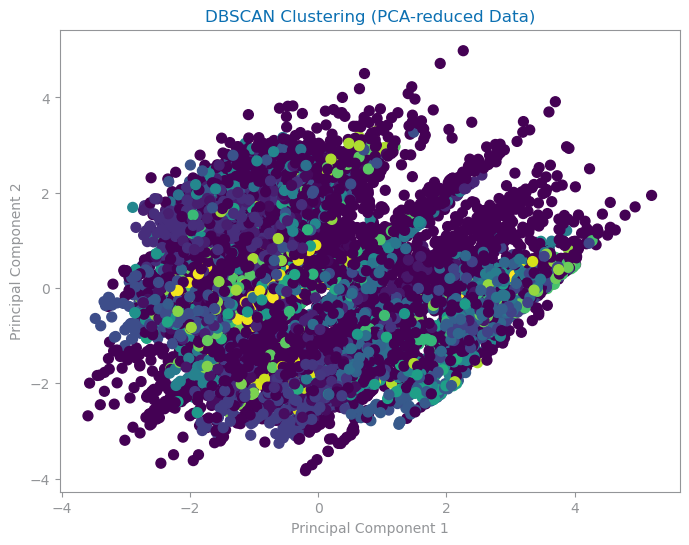

In [395]:
from sklearn.decomposition import PCA

# Aplicar PCA para reduzir as dimensões para 2
pca = PCA(n_components=5)
df_pca = pca.fit_transform(df_to_use_clust.drop('cluster', axis=1))  # Excluindo a coluna 'cluster' para aplicar o PCA

# Plotar os clusters em 2D após a redução de dimensionalidade
plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=df_to_use_clust['cluster'], cmap='viridis', s=50)
plt.title('DBSCAN Clustering (PCA-reduced Data)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Clustering approaches Evaluation

In [376]:

from sklearn.metrics import silhouette_score, adjusted_rand_score


# Intrinsic Evaluation
silhouette_kmeans = silhouette_score(df_to_use_clust, citibike_y_pred_kmeans)
silhouette_agglo = silhouette_score(df_to_use_clust, citibike_y_pred_agglo)

print(f'Silhouette Score for KMeans: {silhouette_kmeans}')
print(f'Silhouette Score for Agglomerative Clustering: {silhouette_agglo}')



Silhouette Score for KMeans: 0.06986905057787081
Silhouette Score for Agglomerative Clustering: 0.8028916371458049


## Cluster Labeling

In [377]:
# Add cluster labels to the dataframe
df_to_use_clust['kmeans_cluster'] = citibike_y_pred_kmeans
df_to_use_clust['agglo_cluster'] = citibike_y_pred_agglo

# Display the dataframe with the new cluster labels
df_to_use_clust.head()

,bike_type,user_type,day_of_month,is_weekend,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,ride_distance_km,...,start_borough_Staten Island,end_borough_Jersey City,end_borough_Staten Island,wmo_weather_desc_Clear sky,wmo_weather_desc_Drizzle: Light,wmo_weather_desc_Mainly clear,wmo_weather_desc_Overcast,wmo_weather_desc_Partly cloudy,kmeans_cluster,agglo_cluster
2275592,0.749091,0.485502,1.587598,-0.659940,-0.231809,1.388599,-0.209668,-0.309892,-0.532121,0.064925,...,-0.025294,-0.0146,-0.02921,-0.702872,-0.212654,-0.331871,1.142899,-0.293661,0,0
1041224,0.749091,-2.059723,0.344719,1.515289,2.271978,0.994829,-0.209668,-0.309892,-0.442361,1.314548,...,-0.025294,-0.0146,-0.02921,1.422733,-0.212654,-0.331871,-0.874968,-0.293661,0,0
196201,0.749091,0.485502,0.966158,-0.659940,-1.046750,-1.492139,-0.209668,-0.439330,-0.980918,-1.180854,...,-0.025294,-0.0146,-0.02921,-0.702872,-0.212654,-0.331871,1.142899,-0.293661,1,0
2253083,-1.334951,0.485502,0.220431,-0.659940,-0.599747,-0.186481,-0.209668,-0.309892,0.724511,-0.623092,...,-0.025294,-0.0146,-0.02921,-0.702872,-0.212654,-0.331871,1.142899,-0.293661,0,0
2539636,0.749091,0.485502,0.469007,1.515289,-0.600775,-1.637212,-0.209668,-0.439330,-0.891159,-0.049651,...,-0.025294,-0.0146,-0.02921,-0.702872,-0.212654,-0.331871,1.142899,-0.293661,0,0


In [271]:
df_to_use_clust.shape

(9195, 33)

### User Order Cluster Counts

In [378]:
# Group by kmeans_cluster and count the number of user IDs
kmeans_cluster_counts = df_to_use_clust.groupby('kmeans_cluster').size()

# Group by agglo_cluster and count the number of user IDs
agglo_cluster_counts = df_to_use_clust.groupby('agglo_cluster').size()

print("KMeans Cluster Counts:")
print(kmeans_cluster_counts)

print("\nAgglomerative Clustering Counts:")
print(agglo_cluster_counts)

KMeans Cluster Counts:
kmeans_cluster
0    3925
1    5459
dtype: int64

Agglomerative Clustering Counts:
agglo_cluster
0    9370
1       2
2       2
3       4
4       6
dtype: int64


In [274]:
agglo_weird_cluster = df_to_use_clust[df_to_use_clust['agglo_cluster']==1]

agglo_weird_cluster

,bike_type,user_type,day_of_month,is_weekend,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,ride_distance_km,...,end_borough_Manhattan,end_borough_Queens,end_borough_Staten Island,wmo_weather_desc_Clear sky,wmo_weather_desc_Drizzle: Light,wmo_weather_desc_Mainly clear,wmo_weather_desc_Overcast,wmo_weather_desc_Partly cloudy,kmeans_cluster,agglo_cluster
287316,0.748372,0.46574,-1.280433,1.495886,-0.886711,0.191684,-0.224772,-0.458532,1.168207,-0.820993,...,-1.303098,-0.240054,-0.01475,-0.699162,-0.220138,-0.333635,-0.836251,3.164171,1,1


### User Order cluster boxplots

In [275]:

import seaborn as sns

def plot_cluster_boxplots(dataframe, features, cluster_labels):
    """
    Plots boxplots for the given features in the dataframe, comparing the specified cluster labels.

    Parameters:
    dataframe (pd.DataFrame): The dataframe containing the data.
    features (list): List of features to plot.
    cluster_labels (list): List of cluster labels to compare.
    """
    # Create subplots
    fig, axes = plt.subplots(nrows=len(features), ncols=len(cluster_labels), figsize=(15, 5 * len(features)))

    # Loop through each feature and create boxplots
    for i, feature in enumerate(features):
        for j, cluster_label in enumerate(cluster_labels):
            sns.boxplot(x=cluster_label, y=feature, data=dataframe, ax=axes[i, j])
            axes[i, j].set_title(f'{cluster_label} - {feature}')

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [277]:
df_to_use_clust.drop(columns = ['kmeans_cluster','agglo_cluster'], inplace = True)

ValueError: Could not interpret value `kmeans_cluster` for `x`. An entry with this name does not appear in `data`.

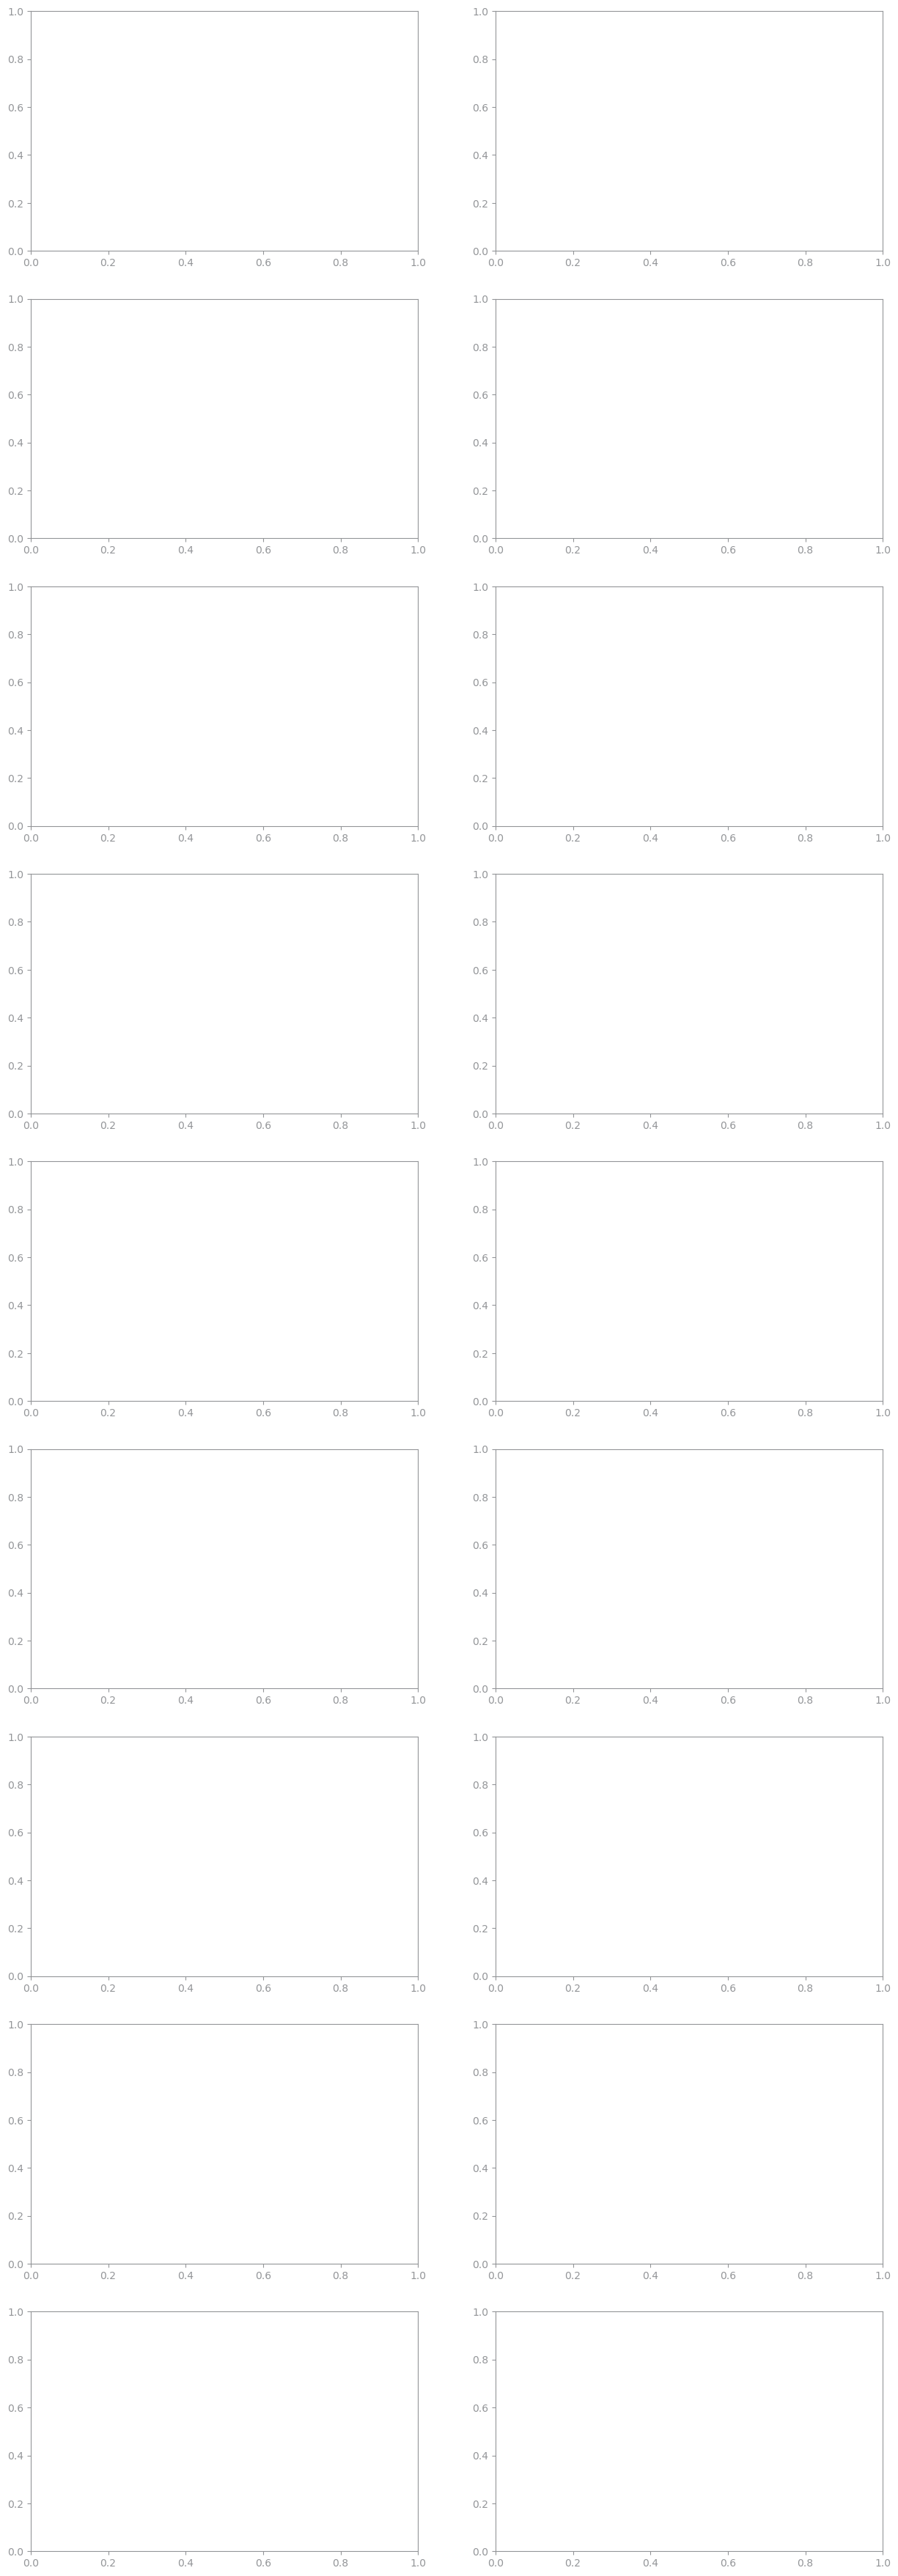

In [278]:
# Example usage
features = numeric


cluster_labels = ['kmeans_cluster', 'agglo_cluster']
plot_cluster_boxplots(df_to_use_clust, features, cluster_labels)

## User Order PCA visualization

In [282]:
from sklearn.decomposition import PCA

#df.drop(columns=['kmeans_cluster', 'agglo_cluster'], inplace=True)

# Visualization
pca_reorder = PCA(n_components=10)
numeric_features_pca = pca_reorder.fit_transform(df_to_use_clust)

pca_reorder_df = pd.DataFrame(numeric_features_pca, columns=[f'PC{i+1}' for i in range(numeric_features_pca.shape[1])])
pca_reorder_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-1.378249,-0.521496,-2.273138,-0.682392,1.460661,-0.326429,0.079595,0.946661,-0.813986,0.587096
1,-1.730843,-1.064233,-0.267706,0.451026,-1.657475,0.332807,1.496256,0.395560,2.251297,0.105029
2,-1.427044,0.264298,-0.286774,-0.797928,0.789030,-0.269944,-0.144275,-0.214446,0.833683,1.594508
3,3.101771,0.396265,-0.211316,-2.726898,0.719383,-0.102051,1.217892,-0.961346,-1.593847,-0.703874
4,0.769518,0.857258,-1.152573,-0.932924,0.092831,0.309615,1.052747,1.485498,-0.163806,0.027014


In [280]:
df.shape

(12774, 17)

## User Order pca explained variance ratio

In [283]:
# Fit the PCA model


pca_reorder.fit(df_to_use_clust)

# Explained variance ratio
explained_variance_reorder = pca_reorder.explained_variance_ratio_
total_variance_explained = explained_variance_reorder.sum()

print(f'Explained variance ratio: {explained_variance_reorder}')
print(f'Total variance explained: {total_variance_explained:.4f}')


Explained variance ratio: [0.10739992 0.07585962 0.06591467 0.06314432 0.06086337 0.05856195
 0.05474138 0.05216085 0.04836188 0.04382472]
Total variance explained: 0.6308


In [284]:
df.columns
df.shape

(12774, 17)

## PCA plot

### 2D PCA Plot

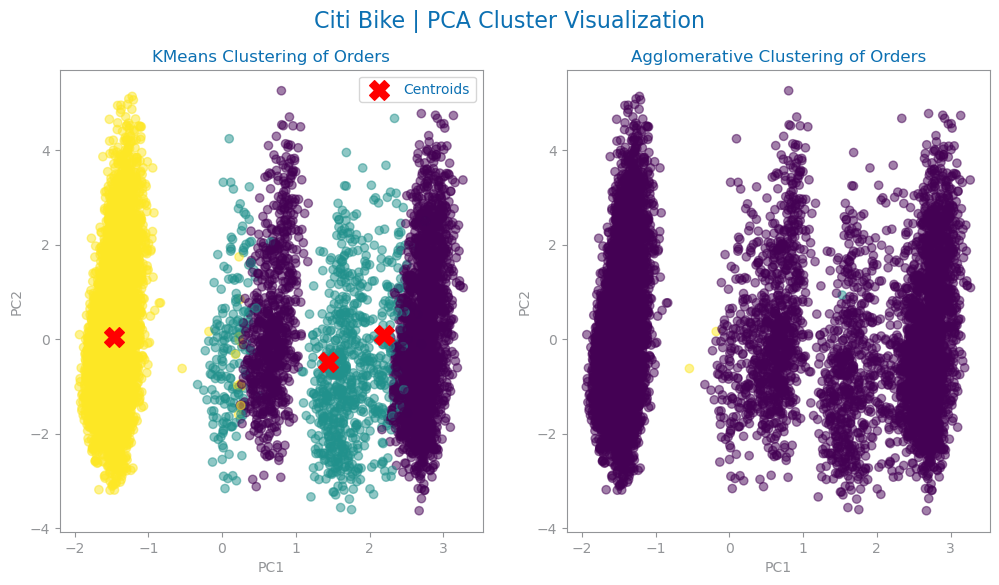

In [285]:
plt.figure(figsize=(12, 6))

# KMeans Clustering
plt.subplot(121)
plt.scatter(pca_reorder_df['PC1'], pca_reorder_df['PC2'], c=citibike_y_pred_kmeans, cmap='viridis', alpha=0.5)
kmeans_centroids = pca_reorder.transform(citibike_kmeans.cluster_centers_)
plt.scatter(kmeans_centroids[:, 0], kmeans_centroids[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('KMeans Clustering of Orders')
plt.legend()

# Agglomerative Clustering
plt.subplot(122)
plt.scatter(pca_reorder_df['PC1'], pca_reorder_df['PC2'], c=citibike_y_pred_agglo, cmap='viridis', alpha=0.5)
# Agglomerative clustering does not have centroids, so we skip this part
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Agglomerative Clustering of Orders')

plt.suptitle(f"{file_tag} | PCA Cluster Visualization", fontsize=16)

plt.show()

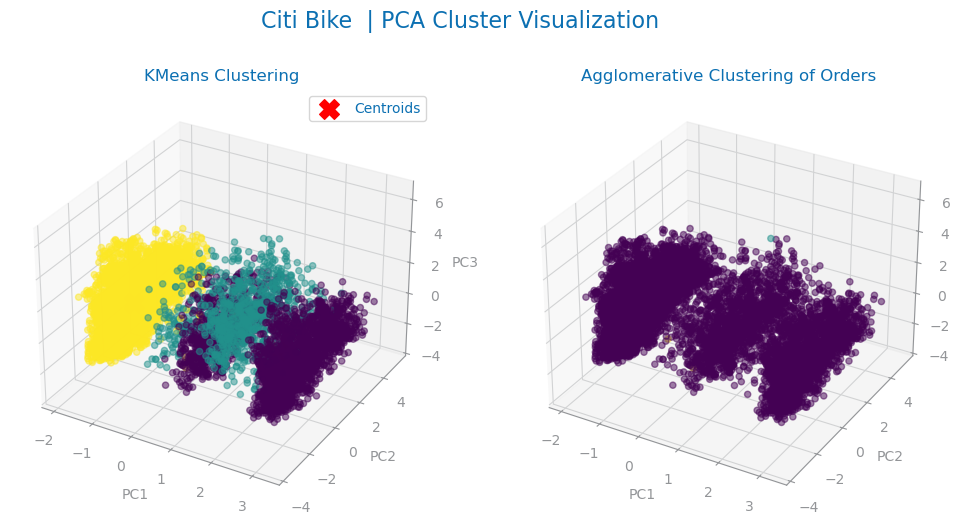

In [286]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 6))

# KMeans Clustering
ax = fig.add_subplot(121, projection='3d')
ax.scatter(pca_reorder_df['PC1'], pca_reorder_df['PC2'], pca_reorder_df['PC3'], c=citibike_y_pred_kmeans, cmap='viridis', alpha=0.5)
kmeans_centroids_3d = pca_reorder.transform(citibike_kmeans.cluster_centers_)
ax.scatter(kmeans_centroids_3d[:, 0], kmeans_centroids_3d[:, 1], kmeans_centroids_3d[:, 2], c='red', marker='X', s=200, label='Centroids')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('KMeans Clustering')
ax.legend()

# Agglomerative Clustering
ax = fig.add_subplot(122, projection='3d')
ax.scatter(pca_reorder_df['PC1'], pca_reorder_df['PC2'], pca_reorder_df['PC3'], c=citibike_y_pred_agglo, cmap='viridis', alpha=0.5)
# Agglomerative clustering does not have centroids, so we skip this part
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Agglomerative Clustering of Orders')

fig.suptitle(f"{file_tag}  | PCA Cluster Visualization", fontsize=16)

plt.show()